In [1]:
import pandas as pd
import os
import sys
import pickle
import gzip
print(os.getcwd())
import numpy as np
import multiprocessing as mp
import matplotlib.pyplot as plt
from tqdm import tqdm


/home/mg/ChimeraProject/scripts


In [2]:
def ramka(local_vars,brek=1000):
    dik = {var: sys.getsizeof(obj) for var, obj in local_vars}
    dik = dict(reversed(sorted(dik.items(), key=lambda item: item[1])))
    #print(dik)
    max_key_length = max(len(key) for key in dik)
    stri="_______________________  GB  MB  KB   B"
    c=1
    for key, value in dik.items():
        c+=1
        if c == brek:break
        stri= stri + "\n"+(f'{key.ljust(max_key_length)}: {format(value, ",").replace(",", " "):>15}')
    return stri, dik
print(ramka(list(globals().items()),brek=15)[0])
#ramka(list(globals().items()),brek=15)[1]["str_seq"],ramka(list(globals().items()),brek=15)[1]["seq"]

_______________________  GB  MB  KB   B
tqdm              :           1 704
_i2               :             684
_i1               :             228
_i                :             228
ramka             :             160
open              :             160
In                :             120
_ih               :             120
__doc__           :             105
__vsc_ipynb_file__:              81
plt               :              72
mp                :              72
np                :              72


In [3]:
def discard_kmers_with_low_abund(data, threshold):
    """
    Filters kmers with low abundance.
    Retains only the most abundant kmers contributing to a specified percentage
    of the total abundance.
    Args:
        threshold (float): Percentage of total abundance to retain.
    Returns:
        dict: Filtered `kmer_array` and `index_array`.
    """
    subarray_lengths = np.array([len(subarray) for subarray in data["index_array"]])
    unique_lengths, counts = np.unique(subarray_lengths, return_counts=True)
    sorted_indices = np.argsort(unique_lengths)[::-1]
    sorted_lengths = unique_lengths[sorted_indices]
    max_length = sorted_lengths[0]
    min_length = threshold * max_length
    good_indices = np.where(subarray_lengths >= min_length)[0]
    new_data = {
        "kmer_array": data["kmer_array"][good_indices],
        "index_array": data["index_array"][good_indices],}
    return new_data

In [4]:
different_thres_dict = {}

for kk in [7,8,9,10]:
    pickle_folder = os.path.join('..', 'pickles', 'uchime_ITS2', 'genus_uchime', f'all{kk}mers')
    file_names = os.listdir(pickle_folder)
    lenka = len(file_names)
    # Preload all the data
    preloaded_data = {}
    for n, file_name in enumerate(file_names):
        if n % 200 == 0: 
            print(f"Loading data... {n}/{lenka}{' '*20}", end="\r")
        file_path = os.path.join(pickle_folder, file_name)
        data = np.load(file_path, allow_pickle=True)
        preloaded_data[file_name] = data
    # Now process the data for each threshold
    for threshold in [0.025,0.1,0.2]:
        taxa_kmer_abund_dict = {}
        for n, file_name in enumerate(file_names):
            if n % 200 == 0: 
                print(f"{kk} {threshold}, {n}/{lenka}{' '*20}", end="\r")
            data = preloaded_data[file_name]
            new_data = discard_kmers_with_low_abund(data, threshold)  # Apply function
            # Store results in dictionary with meaningful names
            taxa_kmer_abund_dict[file_name.split(".npz")[0].split("/")[-1]] = new_data
        
        different_thres_dict[f"{kk}mer_{threshold}_thres"] = taxa_kmer_abund_dict

In [ ]:
del(preloaded_data)

#### Now I have for each Genus Kmers with their positions in reads in that genus and I have discarted kmers with low abundace in all reads in that genus

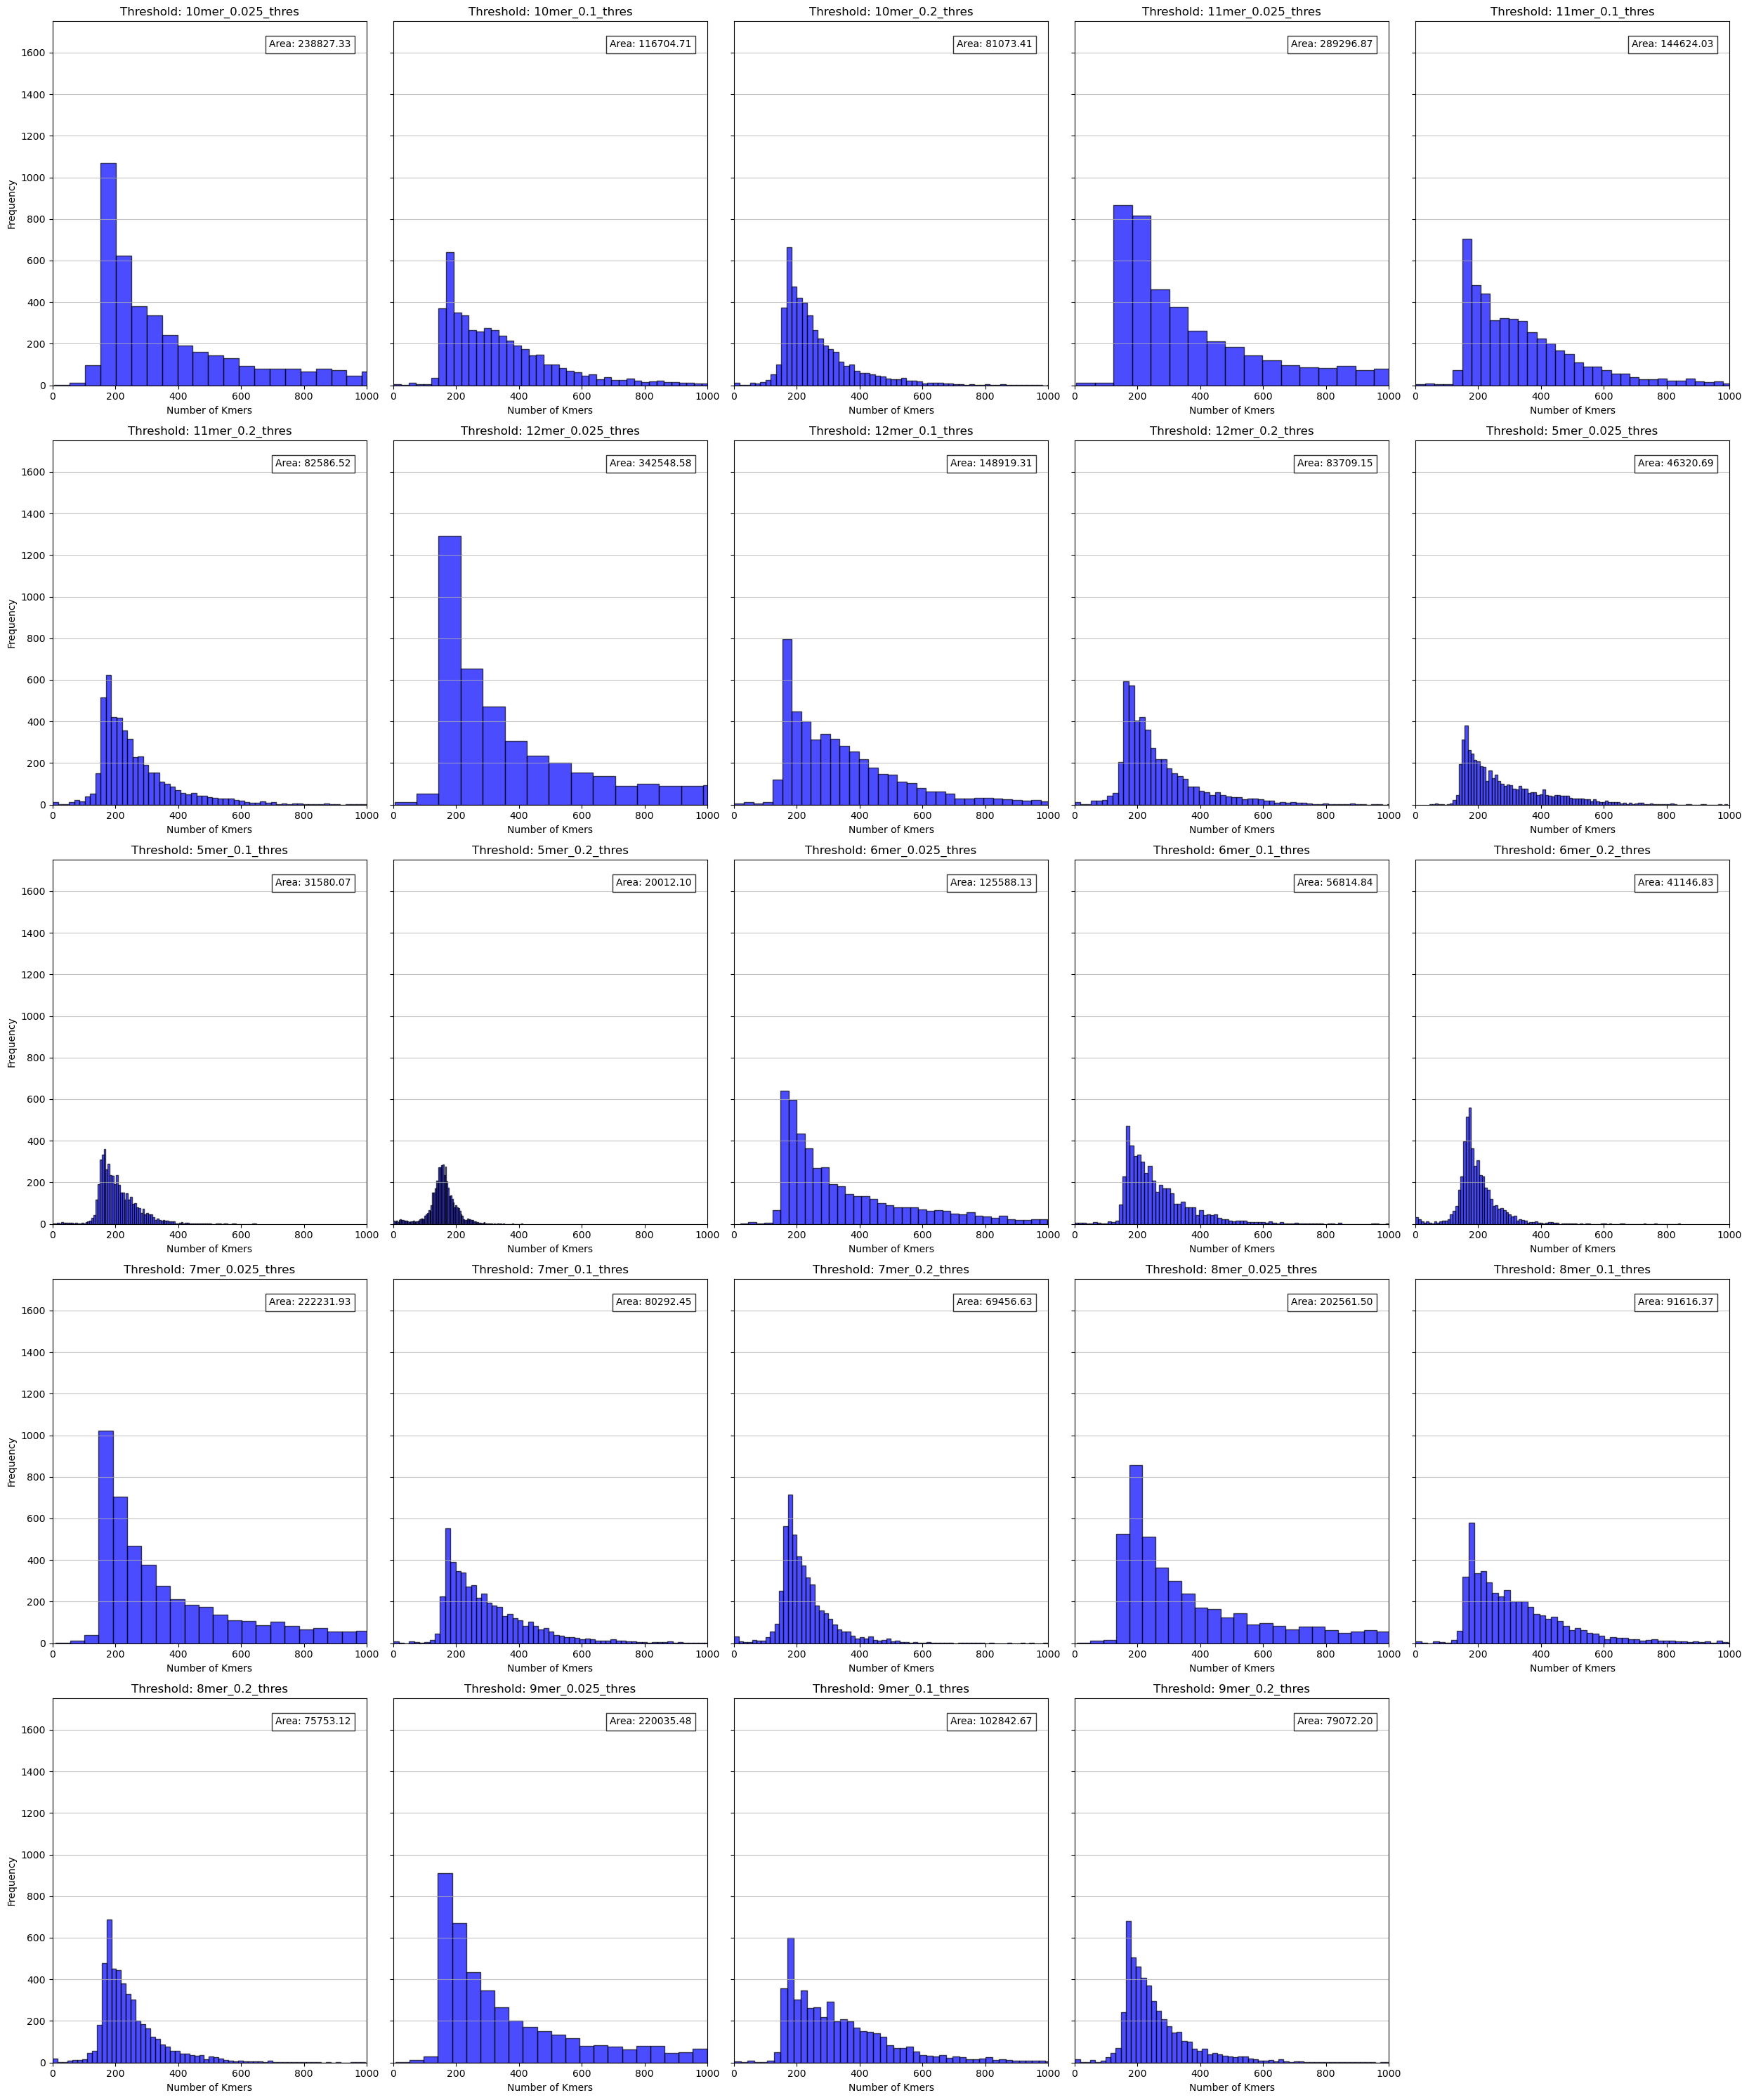

In [ ]:
# plot of the number of kmers in each genus
thresholds = sorted(different_thres_dict.keys())
num_thresholds = len(thresholds)
rows = 5
cols = (num_thresholds + rows - 1) // rows  # Calculate the number of columns needed
fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 6 * rows), sharey=True)

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Fixed max value for x-axis
fixed_x_max = 1000
fixed_y_max = 1750

# Plot histograms for each threshold
for i, threshold in enumerate(thresholds):
    # Compute key_counts for the current threshold
    key_counts = {key: len(value["kmer_array"]) for key, value in different_thres_dict[threshold].items()}
    values = list(key_counts.values())
    
    # Plot the histogram
    counts, bins, patches = axes[i].hist(values, bins=100, color='blue', alpha=0.7, edgecolor='black')
    axes[i].set_title(f'Threshold: {threshold}')
    axes[i].set_xlabel('Number of Kmers')
    axes[i].set_xlim(0, fixed_x_max)  # Set the x-axis limit to 0 to 1600
    axes[i].set_ylim(0, fixed_y_max)
    if i % cols == 0:  # Set ylabel only for the first column
        axes[i].set_ylabel('Frequency')
    
    axes[i].grid(axis='y', alpha=0.75)
    
    # Calculate the total area covered by the bars
    bin_width = bins[1] - bins[0]
    total_area = sum(counts) * bin_width
    
    # Display the total area as text in the plot
    axes[i].text(
        0.95, 0.95, f"Area: {total_area:.2f}",
        transform=axes[i].transAxes,
        fontsize=10,
        verticalalignment='top',
        horizontalalignment='right',
        bbox=dict(facecolor='white', alpha=0.8, edgecolor='black')
    )

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [ ]:
log_of_discarted_kmers_per_threshold = {}
for threshold in different_thres_dict.keys():
    taxa_kmer_abund_dict = different_thres_dict[threshold]
    all_kmers_ever = sum([len([km for km in i["kmer_array"]]) for i in taxa_kmer_abund_dict.values()])
    all_mean_index_ever = np.mean([np.mean([np.mean(ix) for ix in i["index_array"]]) for i in taxa_kmer_abund_dict.values()])
    all_min_index_ever = np.mean([np.mean([np.min(ix) for ix in i["index_array"]]) for i in taxa_kmer_abund_dict.values()])
    all_max_index_ever = np.mean([np.mean([np.max(ix) for ix in i["index_array"]]) for i in taxa_kmer_abund_dict.values()])
    kmers_with_0_position = sum([sum([1 for ix in i["index_array"] if np.max(ix) == 0]) for i in taxa_kmer_abund_dict.values()])
    kmers_with_less50_position = sum([sum([1 for ix in i["index_array"] if np.mean(ix) <50]) for i in taxa_kmer_abund_dict.values()])
    kmers_with_less10_position = sum([sum([1 for ix in i["index_array"] if np.mean(ix) <10]) for i in taxa_kmer_abund_dict.values()])
    no_of_taxa_with_1_kmer = sum([1 for i in taxa_kmer_abund_dict.values() if len(i["kmer_array"]) == 1])
    no_of_taxa_with_less10_kmers = sum([1 for i in taxa_kmer_abund_dict.values() if len(i["kmer_array"]) < 10])
    no_of_taxa_with_0_kmers = sum([1 for i in taxa_kmer_abund_dict.values() if len(i["kmer_array"]) ==0])
    
    #print(all_kmers_ever,all_min_index_ever,all_max_index_ever,all_mean_index_ever)
    log_of_discarted_kmers_per_threshold[threshold] = {
        "all_kmers_ever": all_kmers_ever,
        "all_mean_index_ever": all_mean_index_ever,
        "all_min_index_ever": all_min_index_ever,
        "all_max_index_ever": all_max_index_ever,
        "kmers_with_0_position": kmers_with_0_position,
        "kmers_with_less50_position": kmers_with_less50_position,
        "kmers_with_less10_position": kmers_with_less10_position,
        "no_of_taxa_with_1_kmer": no_of_taxa_with_1_kmer,
        "no_of_taxa_with_less10_kmers": no_of_taxa_with_less10_kmers,
        "no_of_taxa_with_0_kmers": no_of_taxa_with_0_kmers,
    }
    #break
    

In [ ]:
for threshold in different_thres_dict.keys():
    taxa_kmer_abund_dict = different_thres_dict[threshold]
    no_of_kmers_with_abundance_1 = sum([sum([1 for ix in i["index_array"] if len(ix) == 1]) for i in taxa_kmer_abund_dict.values()])

    log_of_discarted_kmers_per_threshold[threshold]["no_of_kmers_with_abundance_1"] = no_of_kmers_with_abundance_1

In [ ]:
for threshold in different_thres_dict.keys():
    taxa_kmer_abund_dict = different_thres_dict[threshold]
    no_of_taxa_with_kmers_with_high_abundance_with_also_kmers_of_abund_1 = sum([1 for i in taxa_kmer_abund_dict.values() if max([len(j) for j in i["index_array"]])>1 and len([1 for j in i["index_array"] if len(j) == 1])>0])

    log_of_discarted_kmers_per_threshold[threshold]["no_of_taxa_with_kmers_with_high_abundance_with_also_kmers_of_abund_1"] = no_of_taxa_with_kmers_with_high_abundance_with_also_kmers_of_abund_1

In [ ]:

taxa_kmer_abund_dict[list(taxa_kmer_abund_dict.keys())[0]]["index_array"][:10]

array([[86],
       [108],
       [28],
       [166],
       [27],
       [77],
       [175],
       [132],
       [43],
       [158]], dtype=object)

In [ ]:

taxa_kmer_abund_dict[list(taxa_kmer_abund_dict.keys())[0]]["index_array"][:10]

array([array([10], dtype=uint16), array([13], dtype=uint16),
       array([110], dtype=uint16), array([129], dtype=uint16),
       array([92], dtype=uint16), array([98], dtype=uint16),
       array([74], dtype=uint16), array([50], dtype=uint16),
       array([128], dtype=uint16), array([160], dtype=uint16)],
      dtype=object)

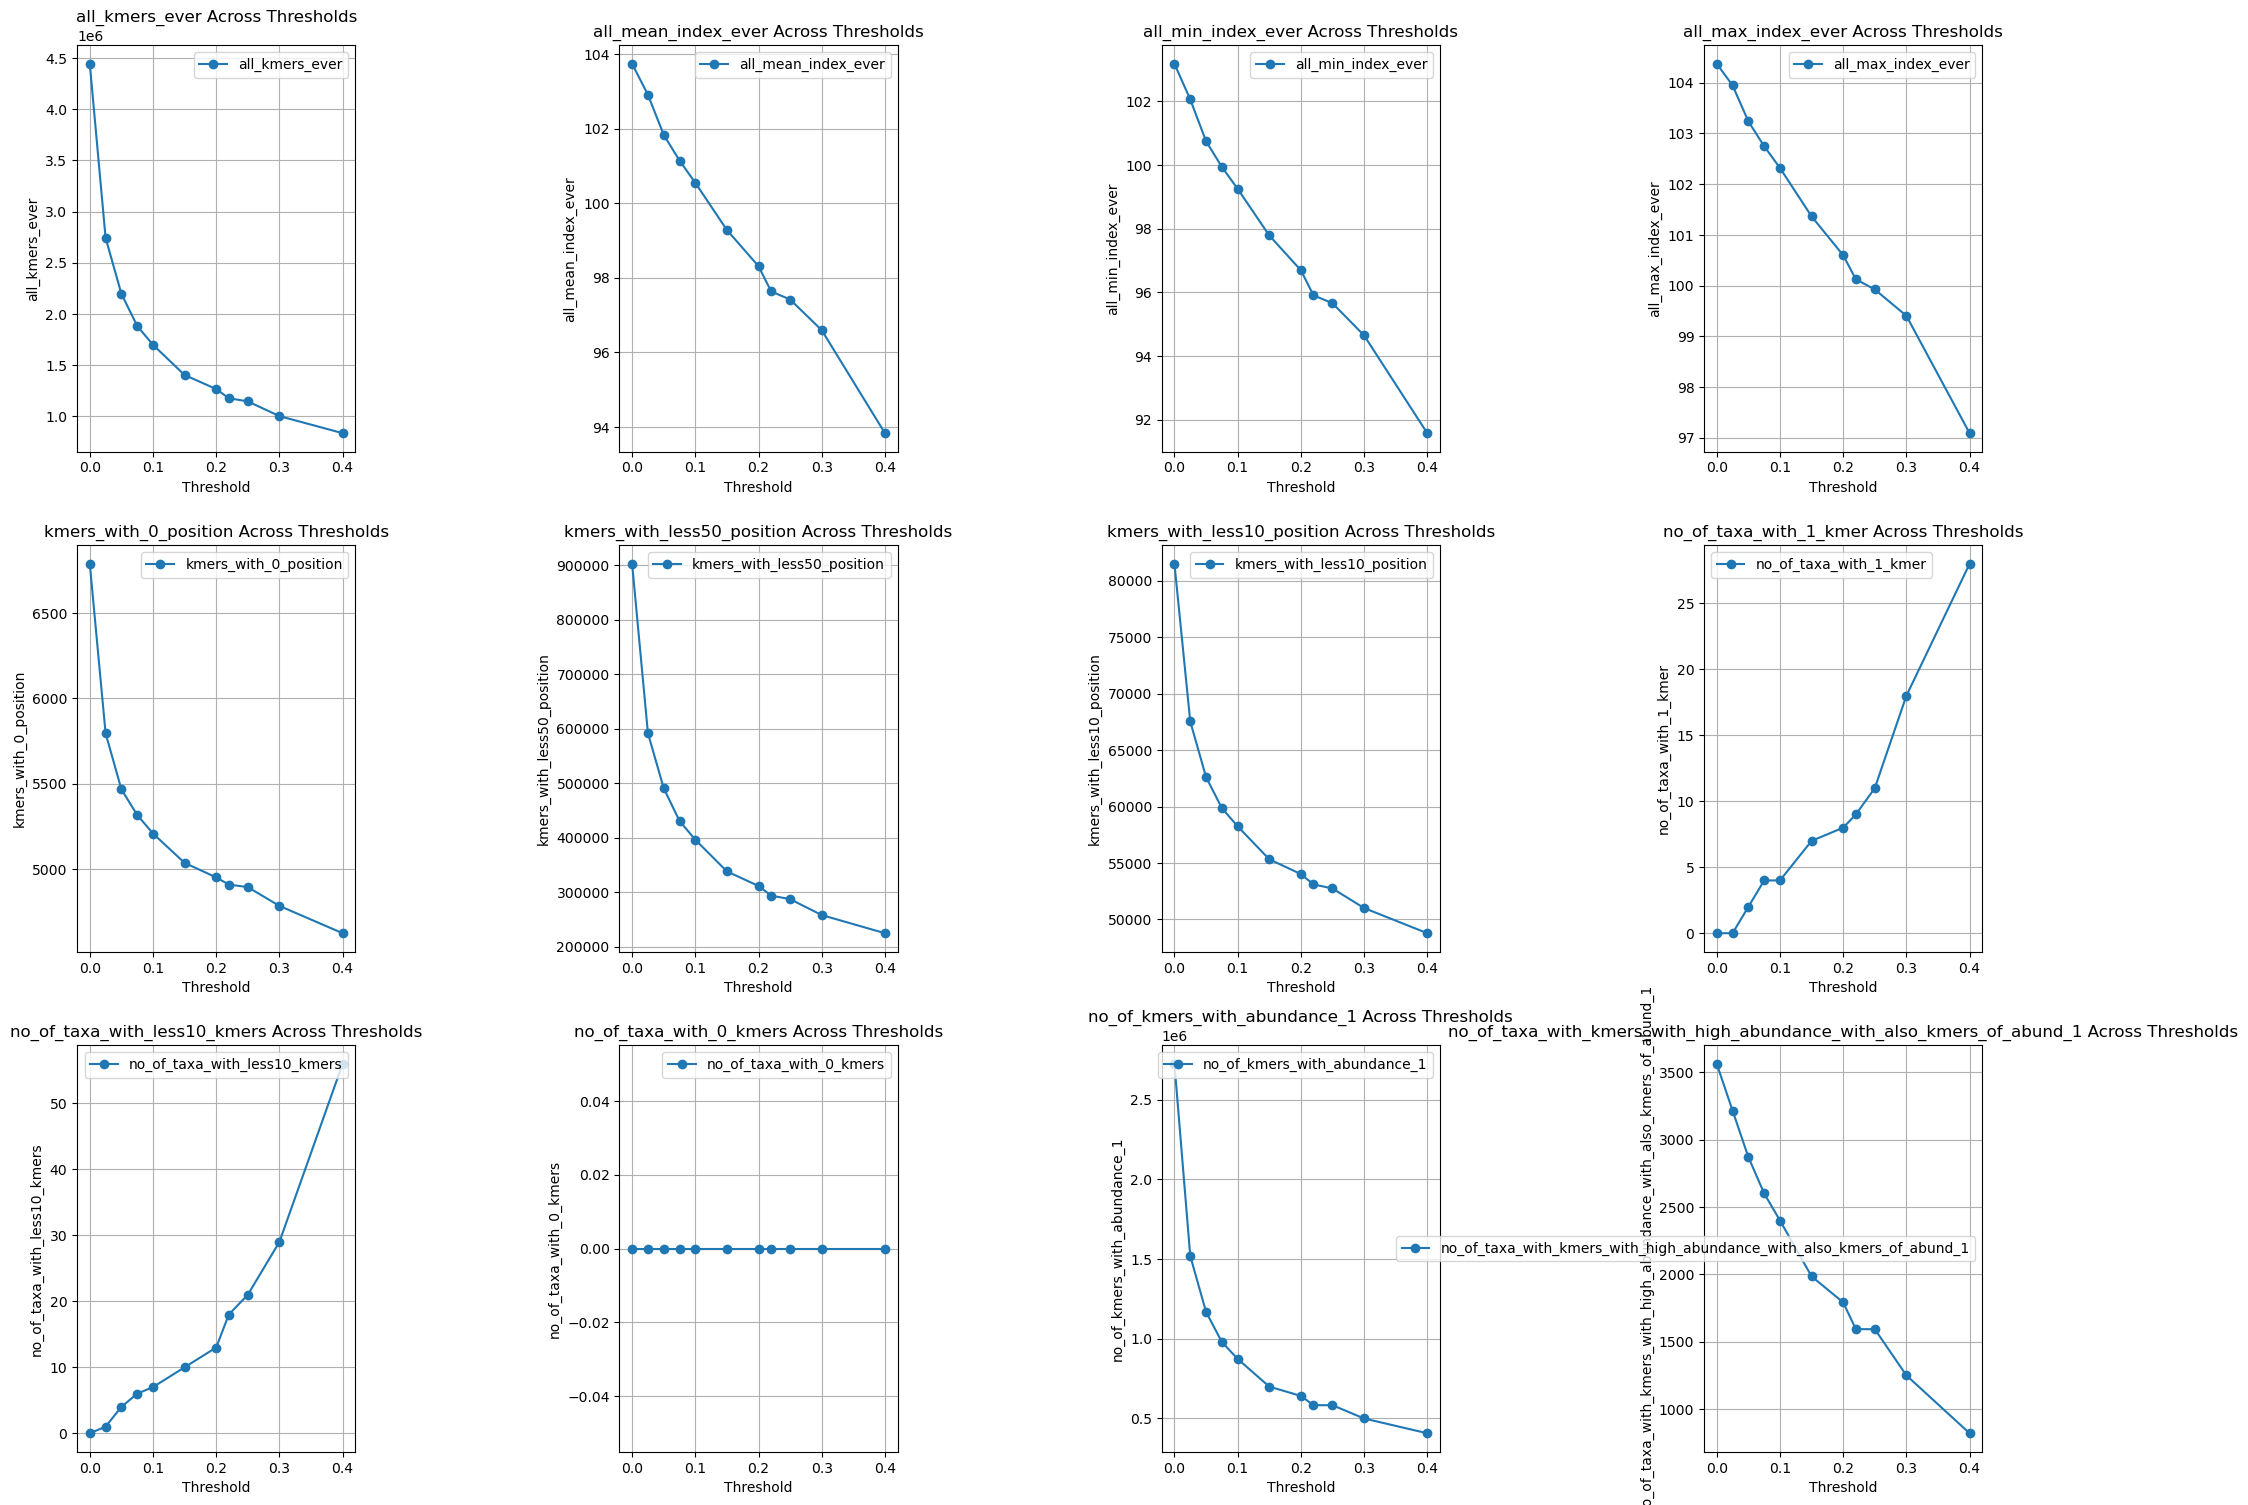

In [ ]:
import math

# Extract thresholds
thresholds = sorted(log_of_discarted_kmers_per_threshold.keys())

# Get all keys from the first threshold's dictionary
keys = list(log_of_discarted_kmers_per_threshold[thresholds[0]].keys())

# Determine the number of rows and columns for the grid
num_keys = len(keys)
num_cols = math.ceil(num_keys / 3)  # 3 rows, so divide keys into columns

# Create the figure
plt.figure(figsize=(20, 15))

# Plot each key
for i, key in enumerate(keys):
    #if key == "no_of_taxa_with_kmers_with_high_abundance_with_also_kmers_of_abund_1":
        #break
    # Extract values for the current key across all thresholds
    values = [
        log_of_discarted_kmers_per_threshold[threshold][key]
        for threshold in thresholds
    ]
    
    # Create a subplot for the current key
    plt.subplot(3, num_cols, i + 1)
    plt.plot(thresholds, values, marker="o", linestyle="-", label=key)
    plt.title(f"{key} Across Thresholds")
    plt.xlabel("Threshold")
    plt.ylabel(key)
    #plt.yscale("log")
    plt.grid(True)
    plt.legend()

# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
# best threshold is 0.2
taxa_kmer_abund_dict = different_thres_dict[0.22]
#del(different_thres_dict)

### So I have discarted kmers with that are in the last quartile juding from its abundance - this will filter out kmers with low abundace reads per each genus and it also removes all those kmers with abundance of 1 - these are probably mistakes

In [ ]:
from Bio import SeqIO
origi_sequences_for_simera = [(record.id, str(record.seq)) for record in SeqIO.parse("../datasets/uchime_reference_dataset_16_10_2022/2022_10_26_chimera_reference_release/ITS1_ITS2_datasets/uchime_reference_dataset_16_20_2022_ITS2.fasta", "fasta")]
genus_read_count = [i for i in origi_sequences_for_simera if "g__Cladophialophora" in i[0]]
len(genus_read_count),genus_read_count[:2] # there were 13 reads of genus Zymoseptoria

(1888,
 [('Cladophialophora_sp|UDB02869914|SH0901951.09FU|reps|k__Fungi;p__Ascomycota;c__Eurotiomycetes;o__Chaetothyriales;f__Herpotrichiellaceae;g__Cladophialophora;s__Cladophialophora_sp',
   'GTTCGAGCGTCATTTTCACTCCCTCAGGCCTCCTGGCCTTGGTGTTGGACGGCTTGGTTTTGGTGACAGAACCCCTCCGAAAGTGAATGACGGCGGCCTGTGGGACCCCCGGTACACTGAGCTTCTTTGATCGAGCACGTATCGGTTTTTAAAGGGTGGACAGGACCCGGTCTTCTTCCTTGACTGGAAACAATCCATTTTCCAAA'),
  ('Cladophialophora_sp|UDB02885146|SH0901952.09FU|reps|k__Fungi;p__Ascomycota;c__Eurotiomycetes;o__Chaetothyriales;f__Herpotrichiellaceae;g__Cladophialophora;s__Cladophialophora_sp',
   'GTTCGAGCGTCATTATCACCCCTCAAGCCCCTGGCTTGGTGTTGGACGGTTTGGTTTTGGCAACAAGACCCCTCCTAAAGTCAACGACGGCGGCCTGGTCGACCCCCGGTACACTGAGCTTCTTAACAGAGCACGTATCGGTCTTCAAGAGTCGGCAGGCCCCGGTCTTCTTCCTTAACCGGAAAACCCTCTCCAA')])

#### Now lets look at positions of each kmer - Genera with lot of kmers with max position of 0 and max position of 3500 are suspicious

In [ ]:
# list of maximal position of kmer in genus sequence
all_sequence_lengths = [np.max([np.mean(j) for j in i["index_array"]]) for i in taxa_kmer_abund_dict.values()]
print(sorted(all_sequence_lengths,reverse=True)[:15])
print(len(all_sequence_lengths))
outlier_out_all_sequence_lengths = [i for i in all_sequence_lengths if i < 350]
print(sorted(outlier_out_all_sequence_lengths,reverse=True)[:15])
print(len(outlier_out_all_sequence_lengths))
print(sorted(outlier_out_all_sequence_lengths)[:15])
print(sum([1 for i in all_sequence_lengths if i ==0 ]))

# I can distar

[np.float64(3597.0), np.float64(819.0), np.float64(755.0), np.float64(701.0), np.float64(699.5), np.float64(655.0), np.float64(638.0), np.float64(618.4375), np.float64(609.5), np.float64(582.75), np.float64(564.1428571428571), np.float64(561.5), np.float64(539.0), np.float64(537.0), np.float64(526.0)]
4881
[np.float64(349.0), np.float64(345.0), np.float64(343.0), np.float64(342.0), np.float64(341.6666666666667), np.float64(340.57142857142856), np.float64(340.5), np.float64(338.0), np.float64(338.0), np.float64(337.6666666666667), np.float64(336.6), np.float64(336.0), np.float64(335.7692307692308), np.float64(335.0), np.float64(335.0)]
4817
[np.float64(55.0), np.float64(56.0), np.float64(57.0), np.float64(58.0), np.float64(58.0), np.float64(60.0), np.float64(61.0), np.float64(62.0), np.float64(62.0), np.float64(64.0), np.float64(67.8), np.float64(70.0), np.float64(77.0), np.float64(80.77272727272727), np.float64(81.0)]
0


In [ ]:
max_0_position_taxa = [(k,v) for k,v in taxa_kmer_abund_dict.items() if np.max([np.mean(j) for j in v["index_array"]]) == 0]
print(len(max_0_position_taxa),max_0_position_taxa[:2])

tax = "g__Agaricus"
print(preloaded_data[tax+".npz"]["kmer_array"][:10])
print(preloaded_data[tax+".npz"]["index_array"][:10])
print()
taxa_kmer_abund_dict[tax]["kmer_array"][:10]
print(preloaded_data[tax+".npz"]["kmer_array"])
print(preloaded_data[tax+".npz"]["index_array"])

0 []
['TTTGGGGTC' 'TATAATCGT' 'AGTGTCGTT' 'TATACGGAG' 'CAGTTTCTA' 'CTACTGAGA'
 'ATAGGTGGA' 'GGTTCAGCT' 'TTGAAYACT' 'GGGGATTTG']
[array([81, 82, 82], dtype=uint16)
 array([189, 189, 187, 190], dtype=uint16) array([5, 5], dtype=uint16)
 array([42], dtype=uint16) array([186], dtype=uint16)
 array([200], dtype=uint16) array([43, 43, 43], dtype=uint16)
 array([ 86, 181,  86,  87,  87,  88], dtype=uint16)
 array([212], dtype=uint16) array([162], dtype=uint16)]

['TTTGGGGTC' 'TATAATCGT' 'AGTGTCGTT' ... 'CTCTTRTAC' 'CAAACTCTC'
 'CTCTGTCAT']
[array([81, 82, 82], dtype=uint16)
 array([189, 189, 187, 190], dtype=uint16) array([5, 5], dtype=uint16) ...
 array([26], dtype=uint16) array([21], dtype=uint16)
 array([172], dtype=uint16)]


#### lot of sequences have max position = 0 of the kmers, weird

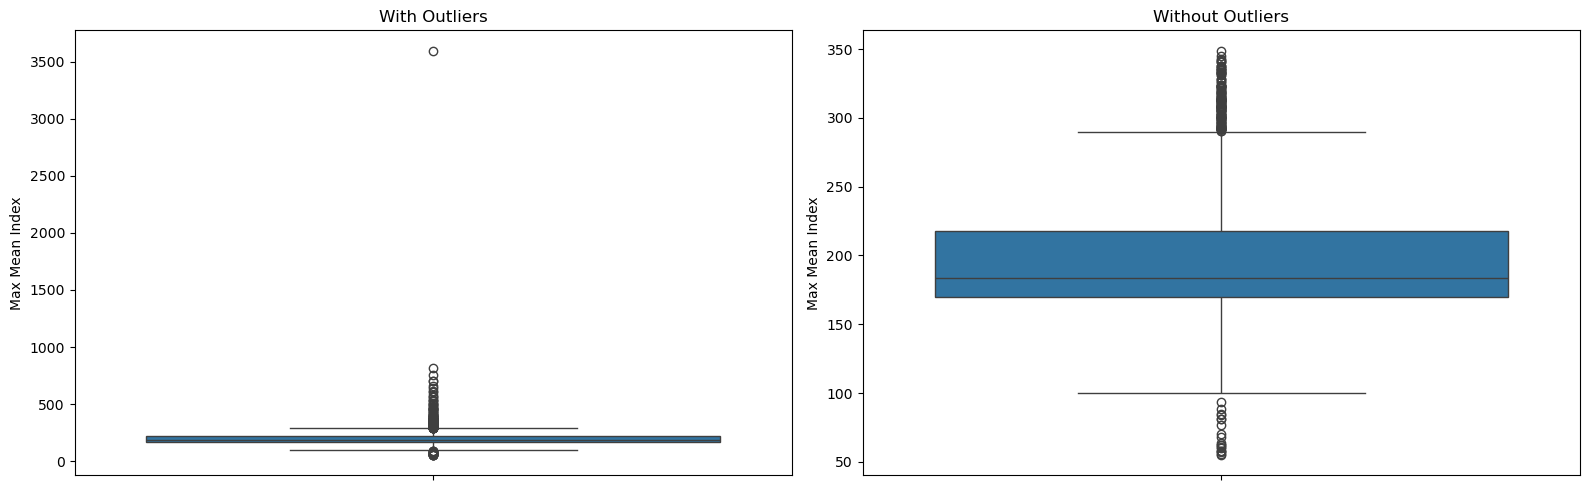

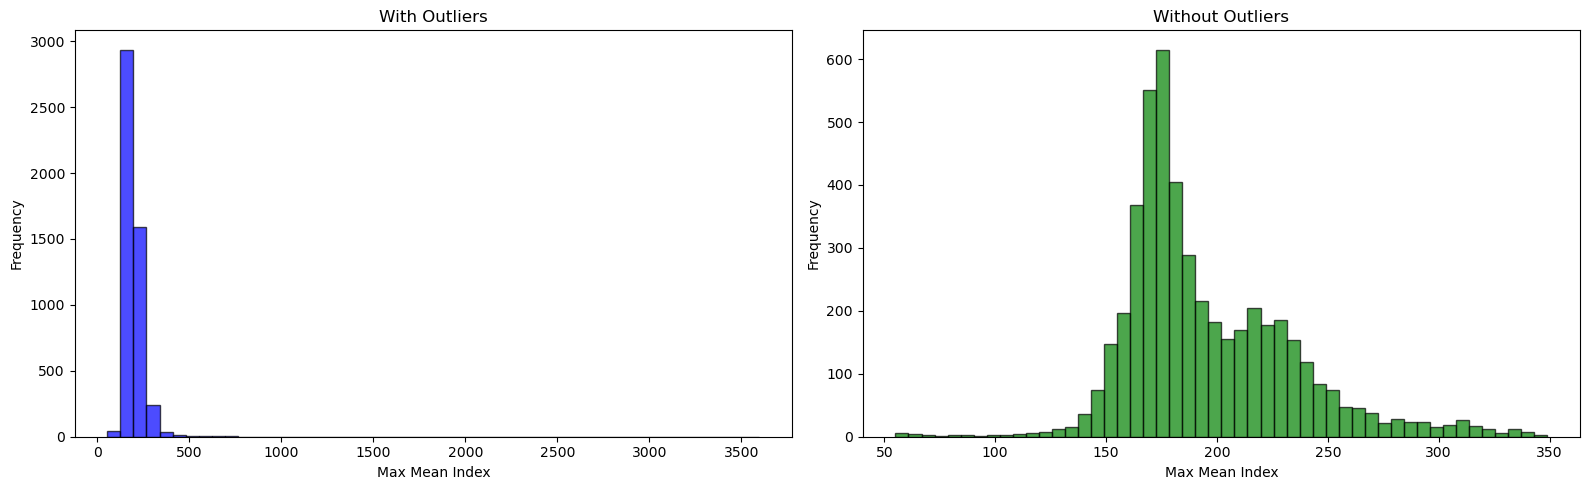

In [ ]:
# plotting the distribution of the maximal position of kmer in genus sequence
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(16, 5))
# Plot with outliers
plt.subplot(1, 2, 1)
sns.boxplot(data=all_sequence_lengths)
plt.ylabel("Max Mean Index")
plt.title("With Outliers")

plt.subplot(1, 2, 2)
sns.boxplot(data=outlier_out_all_sequence_lengths)
plt.ylabel("Max Mean Index")
plt.title("Without Outliers")

plt.tight_layout()
plt.show()
# Plot histograms for the distributions
plt.figure(figsize=(16, 5))

# Histogram with outliers
plt.subplot(1, 2, 1)
plt.hist(all_sequence_lengths, bins=50, color='blue', alpha=0.7, edgecolor='black')
plt.xlabel("Max Mean Index")
plt.ylabel("Frequency")
plt.title("With Outliers")

# Histogram without outliers
plt.subplot(1, 2, 2)
plt.hist(outlier_out_all_sequence_lengths, bins=50, color='green', alpha=0.7, edgecolor='black')
plt.xlabel("Max Mean Index")
plt.ylabel("Frequency")
plt.title("Without Outliers")

plt.tight_layout()
plt.show()

In [ ]:
len(taxa_kmer_abund_dict.keys())

4881

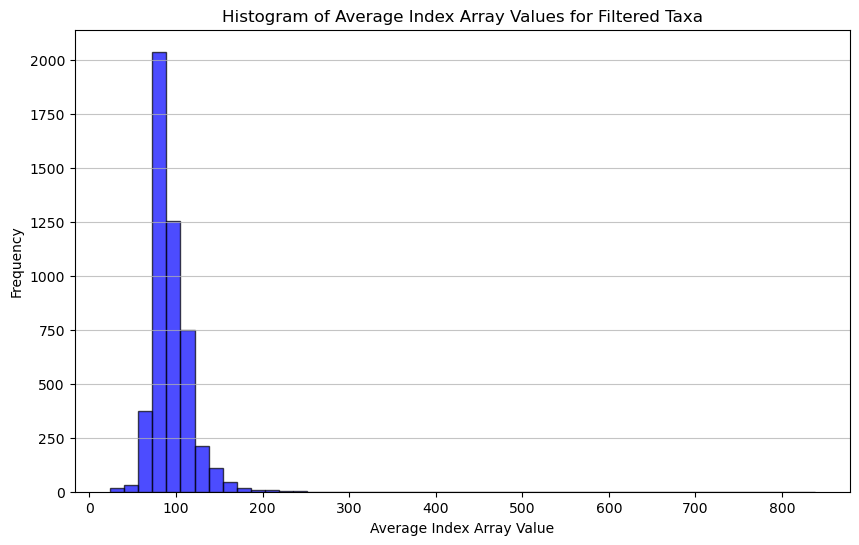

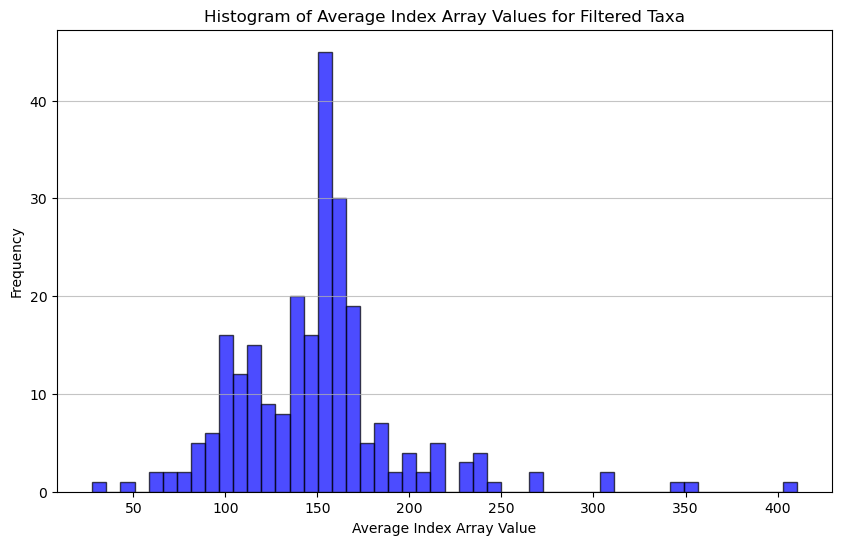

In [ ]:
# Use a set to avoid redundant keys in filtered_taxa_all_positions
filtered_taxa_all_positions = list(taxa_kmer_abund_dict.keys())
# Precompute averages for all taxa in one loop
averages = []
for key in filtered_taxa_all_positions:
    index_array = taxa_kmer_abund_dict[key]["index_array"]
    # Flatten the subarrays and compute the mean directly using NumPy
    flattened = np.concatenate(index_array)
    averages.append(np.mean(flattened))

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(averages, bins=50, color='blue', alpha=0.7, edgecolor='black')
plt.xlabel('Average Index Array Value')
plt.ylabel('Frequency')
plt.title('Histogram of Average Index Array Values for Filtered Taxa')
plt.grid(axis='y', alpha=0.75)
plt.show()


# taxa with big positions of kmers
# here I plot the same thing
filtered_taxa_big_positions = [key for key, value in taxa_kmer_abund_dict.items() if any(np.max(subarray) > 300 for subarray in value["index_array"])]
#len(filtered_keys)
# Calculate the average of value["index_array"] for filtered taxa
averages = [
    np.mean([np.mean(subarray) for subarray in taxa_kmer_abund_dict[key]["index_array"]])
    for key in filtered_taxa_big_positions
]

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(averages, bins=50, color='blue', alpha=0.7, edgecolor='black')
plt.xlabel('Average Index Array Value')
plt.ylabel('Frequency')
plt.title('Histogram of Average Index Array Values for Filtered Taxa')
plt.grid(axis='y', alpha=0.75)
plt.show()

#### This shows that it is ok to discart all indexes that are above 300?

### Now I will load the Simera data

In [2]:
from Bio import SeqIO
import os
prim_dir_list = ['18S-F___5.8S-R', '5.8S_Fun___ITS4_Fun', '58A2F___ITS4', 'fITS7___ITS4', 'fITS9___ITS4', 'FSeq___RSeq', 'gITS7___ITS4', 'gITS7___ITS4ngs', 'gITS7ngs___ITS4ngsUni', 'ITS1___ITS2', 'ITS1___ITS4', 'ITS1___qITS2_', 'ITS1-30F___ITS1-217R', 'ITS1F___58A2R', 'ITS1F___ITS2', 'ITS1F___ITS3', 'ITS1F___ITS4', 'ITS1F___LR6', 'ITS1F_KYO1___ITS2_KYO1', 'ITS1F_KYO1___ITS2_KYO2', 'ITS1F_KYO2___ITS2_KYO2', 'ITS1FI2___5.8S', 'ITS1FI2___ITS2', 'ITS1Fngs___ITS2', 'ITS1ngs___ITS2', 'ITS2F___ITS2R', 'ITS3___ITS4', 'ITS3_KYO2___ITS4', 'ITS3_KYO2___ITS4_KYO3', 'ITS5___5.8S_fungi', 'ITS5___ITS2', 'ITS5___ITS2_KYO2', 'ITS5___ITS4', 'ITS7o___ITS4', 'ITS86F___ITS4', 'ITS86F___ITS4-Tul','ITS9___ITS4','ITS9MUNngs___ITS4ngsUni']
all_amps = {}

for prim_dir in prim_dir_list:
    try:
        prim_path = f'../datasets/uchime_reference_dataset_16_10_2022/2022_10_26_chimera_reference_release/amplicons_from_primers_simera/{prim_dir}/'
        num_dirs = os.listdir(prim_path)
        all_amps[prim_dir] = []
        for num_dir in num_dirs:
            amp_fasta = prim_path + num_dir + "/samp_all_seqs_cutadapt.fa"
            amp_sequences = [(record.id, str(record.seq)) for record in SeqIO.parse(amp_fasta, "fasta")]
            all_amps[prim_dir].extend(amp_sequences)
        all_amps[prim_dir] = set(all_amps[prim_dir])
    except:print(f"{prim_dir} not found")

5.8S_Fun___ITS4_Fun not found
fITS9___ITS4 not found
FSeq___RSeq not found
gITS7ngs___ITS4ngsUni not found
ITS1___ITS2 not found
ITS1___ITS4 not found
ITS1F___ITS3 not found
ITS1FI2___5.8S not found
ITS1FI2___ITS2 not found
ITS1ngs___ITS2 not found
ITS7o___ITS4 not found
ITS86F___ITS4-Tul not found
ITS9___ITS4 not found


In [5]:
len(all_amps["gITS7___ITS4"])
amp_sequences = []
for i in all_amps:
    amp_sequences.extend(all_amps[i])

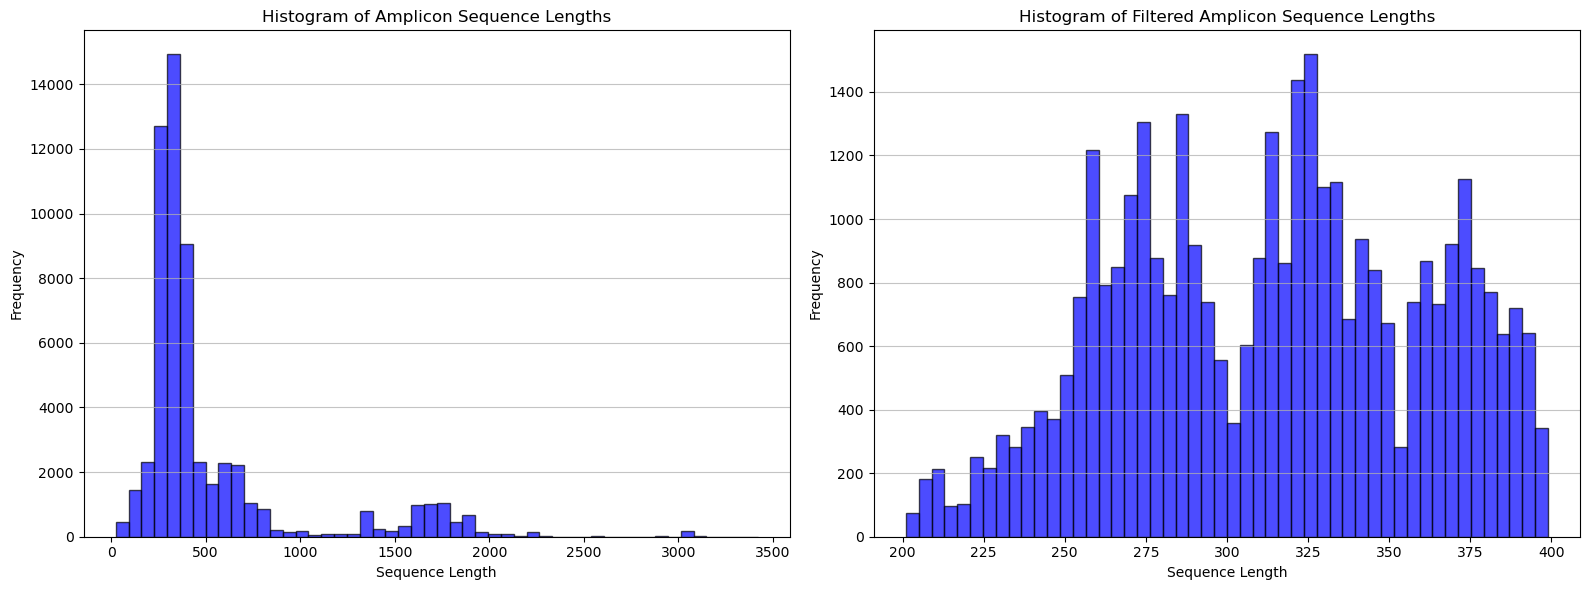

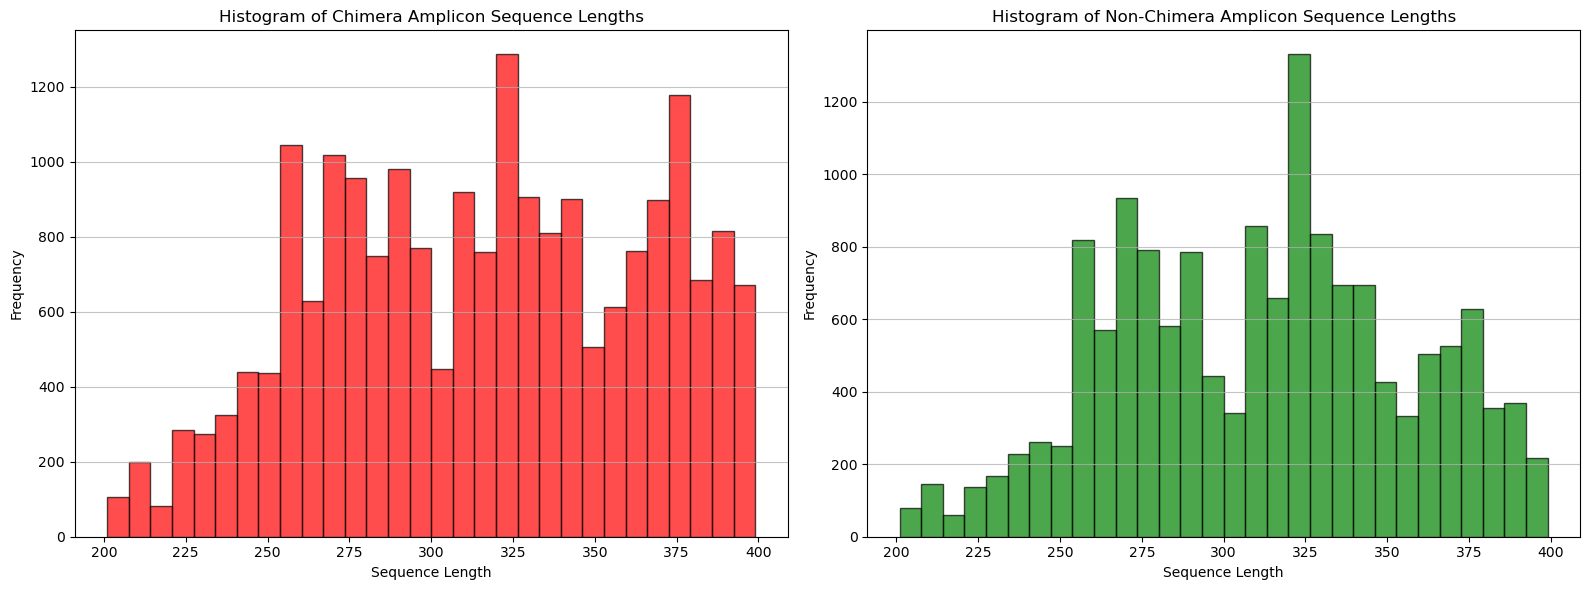

In [7]:
# from Simera fasta I should discard all sequences with length < 250 and > 350
# I ploted all simera read lengths and cut them with min_seq_length = 250 and max_seq_length = 350
import matplotlib.pyplot as plt
min_seq_length = 200
max_seq_length = 400

plt.figure(figsize=(16, 6))

# Subplot 1: Histogram of all sequence lengths
plt.subplot(1, 2, 1)
sequence_lengths = [len(seq[1]) for seq in amp_sequences if len(seq[1])]
plt.hist(sequence_lengths, bins=50, color='blue', alpha=0.7, edgecolor='black')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Histogram of Amplicon Sequence Lengths')
plt.grid(axis='y', alpha=0.75)

# Subplot 2: Histogram of filtered sequence lengths
plt.subplot(1, 2, 2)
filtered_lengths = [len(seq[1]) for seq in amp_sequences if min_seq_length < len(seq[1]) < max_seq_length]
plt.hist(filtered_lengths, bins=50, color='blue', alpha=0.7, edgecolor='black')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Histogram of Filtered Amplicon Sequence Lengths')
plt.grid(axis='y', alpha=0.75)

plt.tight_layout()
plt.show()

# Separate sequence lengths based on "chimera" in the ID
chimera_lengths = [len(seq[1]) for seq in amp_sequences if "chimera" in seq[0] and min_seq_length < len(seq[1]) < max_seq_length]
non_chimera_lengths = [len(seq[1]) for seq in amp_sequences if "chimera" not in seq[0] and min_seq_length < len(seq[1]) < max_seq_length]

# Create a new figure for the chimera and non-chimera histograms
plt.figure(figsize=(16, 6))

# Subplot 1: Histogram for "chimera" reads
plt.subplot(1, 2, 1)
plt.hist(chimera_lengths, bins=30, color='red', alpha=0.7, edgecolor='black')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Histogram of Chimera Amplicon Sequence Lengths')
plt.grid(axis='y', alpha=0.75)

# Subplot 2: Histogram for non-"chimera" reads
plt.subplot(1, 2, 2)
plt.hist(non_chimera_lengths, bins=30, color='green', alpha=0.7, edgecolor='black')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Histogram of Non-Chimera Amplicon Sequence Lengths')
plt.grid(axis='y', alpha=0.75)

plt.tight_layout()
plt.show()

# Filter sequences based on length



In [12]:
for k,v in all_amps.items():
    all_amps[k] = [i for i in all_amps[k] if min_seq_length < len(i[1]) < max_seq_length]
len(all_amps["gITS7___ITS4"])

2816

In [ ]:

###### OLD FUNCTION


import random
from collections import deque
from itertools import combinations,product
from math import sqrt
from time import sleep

def extract_kmers(seq, k_size):
    """Optimized k-mer extraction using slicing."""
    if len(seq) < k_size:
        return set()
    return {seq[i:i + k_size] for i in range(len(seq) - k_size + 1)}

k_count = 9  # 9-mers
part_similarities_for_all_taxa = {}

taxa_kmers_sets = {key: set(taxa_kmers["kmer_array"]) for key, taxa_kmers in taxa_kmer_abund_dict.items()}

a = lambda x: 0.001
b = lambda x: 0.01
c = lambda x: x
d = lambda x: sqrt(x)
e = lambda x: x**(1/3)
f = lambda x: sqrt(sqrt(x))
g = lambda x: x**1.1
h = lambda x: x**1.2
i = lambda x: x**1.3
j = lambda x: x**1.5
k = lambda x: x**2


random.seed(42)
rnd_sample = random.sample(better_amp_sequences, 1000)

sim_modif_funk = [("a",a),("b",b),("c",c),("d",d),("e",e),("f",f),("g",g),("h",h),("i",i),("j",j),("k",k)]
div_div_list = [10,100,1000,10000]
sim_modif_funk_and_div = list(product(sim_modif_funk,div_div_list))
opt_combos = list(product([5],[sim_modif_funk_and_div]))


for n, query_read in enumerate(rnd_sample):
    if n % 10 ==0: print(n,end="\r") 
    for part_number, sim_modif_tup in opt_combos:
        part_similarities_for_all_taxa[query_read[0]] = {}
        
        
        seq = str(query_read[1])
        seq_length = len(seq)
        part_length = seq_length / part_number
        parts = [seq[round(part_length * p):round(part_length * (p + 1))] for p in range(part_number)]

        kmers_in_parts = {}
        for p_num, part in enumerate(parts):
            kmers = extract_kmers(part, k_count)  # Use the optimized k-mer extraction

            best_taxa_for_this_part = [None]*len(sim_modif_tup)
            best_taxa_score = [0]*len(sim_modif_tup)
            for key, taxa_kmers in taxa_kmer_abund_dict.items():
                taxa_kmers_set = taxa_kmers_sets[key]  # Precompute the set once
                common_kmers = kmers & taxa_kmers_set
                intersection = len(common_kmers)
                union = len(kmers) + len(taxa_kmers_set) - intersection  # Faster union computation
                score = intersection  / union if union != 0 else 0
            
                for s_m_n, ((sim_modif_stri, sim_modif),div_div) in enumerate(sim_modif_tup):
                    if score > 0:
                        score2 = score - (sim_modif(len(taxa_kmers_set))/div_div)
                    else: score2 = 0
                    
                    if score2 > best_taxa_score[s_m_n]:
                        best_taxa_score[s_m_n] = score2
                        best_taxa_for_this_part[s_m_n] = key
            #print(kmers,intersection)
                #sys.exit()
                
            kmers_in_parts[p_num + 1] = best_taxa_for_this_part
            #print(kmers_in_parts)
            
            if best_taxa_for_this_part is None:
                pass
                
                #print(f"Best taxa for part {p_num + 1} is None. score: {score} Check the seq: {query_read[0]},{seq}")
                #sys.exit()
        #sys.exit()
        part_similarities = {}
        for part1, part2 in combinations(range(1, part_number + 1), 2):
            #print(part1, part2)
            
            taxa1s = kmers_in_parts.get(part1)
            taxa2s = kmers_in_parts.get(part2)

        
            #print(taxa1s,taxa2s)
            #sys.exit()
            for (taxa1,taxa2),((sim_modif_stri,_),div_div) in zip(zip(taxa1s,taxa2s),sim_modif_tup):
                if taxa1 is None or taxa2 is None:
                    part_similarities[(part1, part2)] = None
                else:    
                    
                    kmers1 = taxa_kmers_sets[taxa1]
                    kmers2 = taxa_kmers_sets[taxa2]
                    
                    intersection = len(kmers1 & kmers2)  # Faster set intersection
                    union = len(kmers1 | kmers2)  # Faster set union
                    similarity = intersection / union if union != 0 else 0  # Jaccard similarity

                    part_similarities[(sim_modif_stri,div_div,part1, part2)] = similarity
                    
            #print(query_read[0], part_similarities,sep="\n")
        part_similarities_for_all_taxa[query_read[0]] = part_similarities
        #print(part_similarities_for_all_taxa)
        #sys.exit()

        

In [9]:
import numpy as np
import time
from collections import Counter
from tqdm.notebook import tqdm

def extract_kmers(seq, k_size):
    """Extract k-mers from a sequence with their positions."""
    if len(seq) < k_size:
        return {}, {}
    
    kmer_positions = {}
    for i in range(len(seq) - k_size + 1):
        kmer = seq[i:i + k_size]
        if kmer not in kmer_positions:
            kmer_positions[kmer] = []
        kmer_positions[kmer].append(i)
    
    return set(kmer_positions.keys()), kmer_positions

def jaccard_similarity(set1, set2):
    """Calculate Jaccard similarity between two sets."""
    if not set1 or not set2:
        return 0.0, set()
    intersection = set1 & set2
    union = len(set1) + len(set2) - len(intersection)
    return len(intersection) / union if union > 0 else 0.0, intersection

def find_top_taxa_matches_batch(sequences, taxa_dict, k_size, top_n=10):
    """
    Find top matching taxa for a batch of sequences using k-mers from taxa_dict.
    
    Args:
        sequences (list): List of tuples (seq_id, sequence)
        taxa_dict (dict): Dictionary with taxa names as keys and k-mer data as values
        k_size (int): Size of k-mers to extract
        top_n (int): Number of top matches to return for each sequence
    
    Returns:
        dict: Dictionary with seq_id as keys and lists of tuples containing:
              (taxon, similarity, avg_position_scaled, stddev_position_scaled) for each match
    """
    start_time = time.time()
    batch_results = {}
    
    # Precompute taxon k-mer sets for faster lookup
    taxon_kmer_sets = {}
    for taxon, taxon_data in taxa_dict.items():
        taxon_kmer_sets[taxon] = set(taxon_data['kmer_array'])
    
    # Process each sequence
    for seq_id, seq in tqdm(sequences, desc="Processing sequences", leave=False):
        seq_kmers, kmer_positions = extract_kmers(seq, k_size)
        
        seq_length = len(seq)  # For scaling positions
        similarities = []
        
        for taxon, taxon_kmers in taxon_kmer_sets.items():
            # Calculate similarity and get the intersection of k-mers
            similarity, matching_kmers = jaccard_similarity(seq_kmers, taxon_kmers)
            
            # Compute position statistics for matching k-mers
            if matching_kmers:
                # Collect all positions for matching k-mers
                all_positions = []
                for kmer in matching_kmers:
                    if kmer in kmer_positions:
                        all_positions.extend(kmer_positions[kmer])
                
                # Calculate statistics
                avg_position = np.mean(all_positions) if all_positions else -1
                stddev_position = np.std(all_positions) if len(all_positions) > 1 else -1
                
                # Scale by sequence length
                avg_position_scaled = avg_position / seq_length
                stddev_position_scaled = stddev_position / seq_length
            else:
                avg_position_scaled = -1
                stddev_position_scaled = -1
            
            # Store results with position statistics
            similarities.append((
                taxon, 
                similarity, 
                avg_position_scaled, 
                stddev_position_scaled
            ))
        
        # Sort by similarity score in descending order and take top_n
        top_matches = sorted(similarities, key=lambda x: x[1], reverse=True)[:top_n]
        batch_results[seq_id] = top_matches
    
    processing_time = time.time() - start_time
    print(f"Processed {len(sequences)} sequences in {processing_time:.2f} seconds")
    return batch_results

In [ ]:
# Example usage in your Jupyter notebook
results = {}

# Loop over primers and thresholds externally
for primer_name, sequences in all_amps.items():
    print(f"Processing primer: {primer_name} with {len(sequences)} sequences")
    results[primer_name] = {}
    
    for threshold, taxa_dict in different_thres_dict.items():
        print(f"  Processing threshold: {threshold}")
        k_size = int(threshold.split('mer')[0]) if isinstance(threshold, str) else 9
        
        # Process the full batch of sequences for this primer and threshold
        threshold_results = find_top_taxa_matches_batch(
            sequences=sequences,
            taxa_dict=taxa_dict,
            k_size=k_size,
            top_n=10
        )
        
        results[primer_name][threshold] = threshold_results
        
        # Example of accessing the results, including position information
        if threshold_results:
            first_seq_id = next(iter(threshold_results))
            matches = threshold_results[first_seq_id]
            print(f"  Sample match for {first_seq_id}:")
            for taxon, similarity, avg_pos, stddev_pos in matches[:3]:  # Show top 3
                print(f"    {taxon}: similarity={similarity:.4f}, avg_pos={avg_pos:.4f}, stddev={stddev_pos:.4f}")
        
        # Optional: Save intermediate results
        import pickle
        with open(f"results_{primer_name}_{threshold}.pkl", "wb") as f:
            pickle.dump(threshold_results, f)
        
        print(f"  Completed {len(threshold_results)} sequences for {primer_name} - {threshold}")

Processing primer: 18S-F___5.8S-R with 2775 sequences
  Processing threshold: 7mer_0.025_thres
Precomputing taxon k-mer sets...


Processing sequences:   0%|          | 0/2775 [00:00<?, ?it/s]

Processed 0/2775 sequences, time elapsed: 0.64s
Processed 100/2775 sequences, time elapsed: 0.74s
Processed 200/2775 sequences, time elapsed: 0.83s
Processed 300/2775 sequences, time elapsed: 0.92s
Processed 400/2775 sequences, time elapsed: 1.01s
Processed 500/2775 sequences, time elapsed: 1.10s
Processed 600/2775 sequences, time elapsed: 1.19s
Processed 700/2775 sequences, time elapsed: 1.27s
Processed 800/2775 sequences, time elapsed: 1.36s
Processed 900/2775 sequences, time elapsed: 1.45s
Processed 1000/2775 sequences, time elapsed: 1.54s
Processed 1100/2775 sequences, time elapsed: 1.63s
Processed 1200/2775 sequences, time elapsed: 1.72s
Processed 1300/2775 sequences, time elapsed: 1.81s
Processed 1400/2775 sequences, time elapsed: 1.90s
Processed 1500/2775 sequences, time elapsed: 1.99s
Processed 1600/2775 sequences, time elapsed: 2.08s
Processed 1700/2775 sequences, time elapsed: 2.17s
Processed 1800/2775 sequences, time elapsed: 2.26s
Processed 1900/2775 sequences, time elapsed

Processing sequences:   0%|          | 0/2775 [00:00<?, ?it/s]

Processed 0/2775 sequences, time elapsed: 0.37s
Processed 100/2775 sequences, time elapsed: 0.47s
Processed 200/2775 sequences, time elapsed: 0.56s
Processed 300/2775 sequences, time elapsed: 0.65s
Processed 400/2775 sequences, time elapsed: 0.74s
Processed 500/2775 sequences, time elapsed: 0.83s
Processed 600/2775 sequences, time elapsed: 0.92s
Processed 700/2775 sequences, time elapsed: 1.00s
Processed 800/2775 sequences, time elapsed: 1.09s
Processed 900/2775 sequences, time elapsed: 1.18s
Processed 1000/2775 sequences, time elapsed: 1.27s
Processed 1100/2775 sequences, time elapsed: 1.36s
Processed 1200/2775 sequences, time elapsed: 1.45s
Processed 1300/2775 sequences, time elapsed: 1.54s
Processed 1400/2775 sequences, time elapsed: 1.62s
Processed 1500/2775 sequences, time elapsed: 1.71s
Processed 1600/2775 sequences, time elapsed: 1.84s
Processed 1700/2775 sequences, time elapsed: 1.93s
Processed 1800/2775 sequences, time elapsed: 2.02s
Processed 1900/2775 sequences, time elapsed

Processing sequences:   0%|          | 0/2775 [00:00<?, ?it/s]

Processed 0/2775 sequences, time elapsed: 0.27s
Processed 100/2775 sequences, time elapsed: 0.37s
Processed 200/2775 sequences, time elapsed: 0.46s
Processed 300/2775 sequences, time elapsed: 0.55s
Processed 400/2775 sequences, time elapsed: 0.63s
Processed 500/2775 sequences, time elapsed: 0.72s
Processed 600/2775 sequences, time elapsed: 0.85s
Processed 700/2775 sequences, time elapsed: 0.95s
Processed 800/2775 sequences, time elapsed: 1.04s
Processed 900/2775 sequences, time elapsed: 1.13s
Processed 1000/2775 sequences, time elapsed: 1.23s
Processed 1100/2775 sequences, time elapsed: 1.32s
Processed 1200/2775 sequences, time elapsed: 1.41s
Processed 1300/2775 sequences, time elapsed: 1.50s
Processed 1400/2775 sequences, time elapsed: 1.60s
Processed 1500/2775 sequences, time elapsed: 1.69s
Processed 1600/2775 sequences, time elapsed: 1.78s
Processed 1700/2775 sequences, time elapsed: 1.87s
Processed 1800/2775 sequences, time elapsed: 1.97s
Processed 1900/2775 sequences, time elapsed

KeyboardInterrupt: 

In [27]:
# Code to visualize position stats for chimeras vs non-chimeras
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Pick a primer and get sequences
sequences=[]
iii = list(all_amps.keys())
for i in iii:
    sequences.extend(list(all_amps[i]))  # Extend with second primer sequences
print(f"Primer: all_primers with {len(sequences)} sample sequences")
# Get a threshold/k-mer setting
threshold = next(iter(different_thres_dict.keys()))
k_size = int(threshold.split('mer')[0])
print(f"Using threshold: {threshold}, k-mer size: {k_size}")

# Process sequences
results_7 = find_top_taxa_matches_batch(
    sequences=sequences,
    taxa_dict=different_thres_dict[threshold],
    k_size=k_size,
    top_n=100  # Top 5 matches per sequence is enough
)
from time import sleep
sleep(60)
results_10 = find_top_taxa_matches_batch(
    sequences=sequences,
    taxa_dict=different_thres_dict["10mer_0.025_thres"],
    k_size=k_size,
    top_n=100  # Top 5 matches per sequence is enough
)


Primer: all_primers with 35456 sample sequences
Using threshold: 7mer_0.025_thres, k-mer size: 7


Processing sequences:   0%|          | 0/35456 [00:00<?, ?it/s]

Processed 35456 sequences in 8001.72 seconds


Processing sequences:   0%|          | 0/35456 [00:00<?, ?it/s]

Processed 35456 sequences in 1430.86 seconds


In [ ]:
#pd.DataFrame({"7":[results_7],"10":[results_10]}).to_pickle("results_7_10_top_taxa_matches.pickle")

In [51]:
results_7[list(results_7.keys())[20]]

[('g__Coleosporium',
  0.048462255358807084,
  0.6030494821634063,
  0.23533115655039838),
 ('g__Zancudomyces',
  0.04489164086687306,
  0.5892998417721519,
  0.24903139951221603),
 ('g__Clydaea', 0.04259259259259259, 0.6570411392405063, 0.2332574244925332),
 ('g__Schizosaccharomyces',
  0.042488619119878605,
  0.47468354430379744,
  0.29352541588889475),
 ('g__Piromyces', 0.04229934924078091, 0.5769778481012657, 0.2626976746152838),
 ('g__Pucciniastrum',
  0.042114695340501794,
  0.5703952467062775,
  0.24494247502873925),
 ('g__Acaulospora',
  0.041309431021044424,
  0.49478434130332866,
  0.30627624409562676),
 ('g__Macrorhabdus',
  0.040948275862068964,
  0.5561292471685543,
  0.28444873456575165),
 ('g__Lasiobolidium',
  0.04091816367265469,
  0.5639384349827388,
  0.22772877935564054),
 ('g__Pandora', 0.0407098121085595, 0.5806556312885427, 0.2564156230565051),
 ('g__Amyloathelia',
  0.040421792618629174,
  0.5295817281232802,
  0.1746552481799482),
 ('g__Peziza', 0.0402245088868

Analyzing top_n values:   0%|          | 0/36 [00:00<?, ?it/s]

Optimal top_n for avg_pos variance difference: 55.0
Optimal top_n for stddev_pos variance difference: 1.0


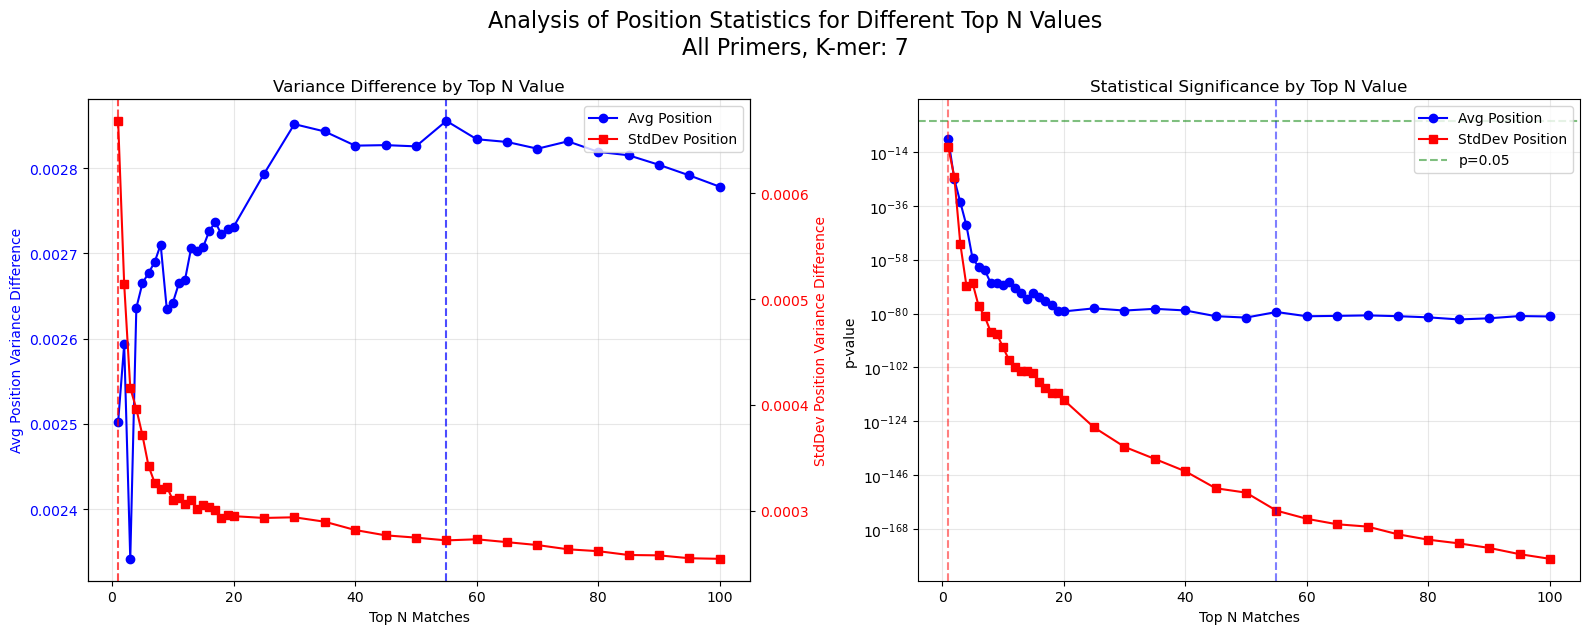

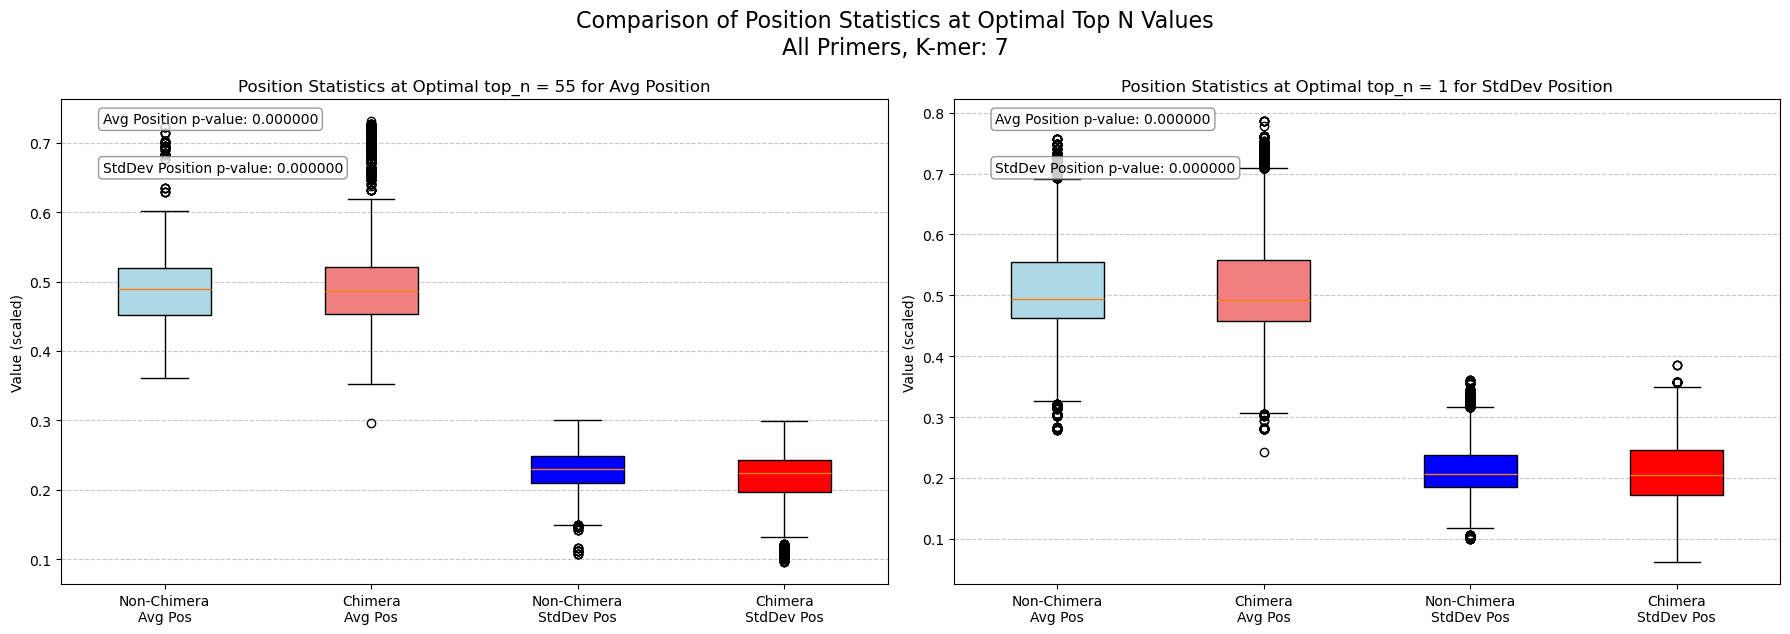


Detailed statistics for optimal avg_pos top_n = 55:

Chimera sequences:
            avg_pos    stddev_pos
count  20443.000000  20443.000000
mean       0.497061      0.219666
std        0.070791      0.032539
min        0.296045      0.095939
25%        0.453427      0.196279
50%        0.486868      0.223630
75%        0.520568      0.243019
max        0.731264      0.299746

Non-chimera sequences:
            avg_pos    stddev_pos
count  15013.000000  15013.000000
mean       0.485215      0.228446
std        0.046431      0.028049
min        0.360482      0.106873
25%        0.451478      0.209488
50%        0.489830      0.229648
75%        0.519876      0.249413
max        0.723301      0.299940

Detailed statistics for optimal stddev_pos top_n = 1:

Chimera sequences:
            avg_pos    stddev_pos
count  20443.000000  20443.000000
mean       0.515465      0.210987
std        0.089848      0.050212
min        0.243243      0.061899
25%        0.457119      0.171701
50%        0

In [67]:

from scipy import stats
top_n_stats = []
df_pos_all_top_n = {}
# Analyze different top_n values
for top_n in tqdm(list(range(1,20,1))+list(range(20, 101, 5)), desc="Analyzing top_n values"):
    # Extract position statistics for this top_n value
    position_stats = []
    for seq_id, seq in sequences:
        is_chimera = 'chimera' in seq_id.lower()
        matches = results[seq_id][:top_n]  # Use only top_n matches
        
        if matches:
            # Get average stats across all matches up to top_n
            avg_positions = []
            stddev_positions = []
            
            for taxon, similarity, avg_pos, stddev_pos in matches:
                if avg_pos >= 0 and stddev_pos >= 0:  # Skip invalid values
                    avg_positions.append(avg_pos)
                    stddev_positions.append(stddev_pos)
            
            if avg_positions and stddev_positions:
                # Calculate mean of means and mean of standard deviations
                avg_pos_mean = np.mean(avg_positions)
                stddev_pos_mean = np.mean(stddev_positions)
                
                position_stats.append({
                    'seq_id': seq_id,
                    'is_chimera': is_chimera,
                    'avg_pos': avg_pos_mean,
                    'stddev_pos': stddev_pos_mean
                })
    
    # Convert to DataFrame
    df_pos = pd.DataFrame(position_stats)
    
    # Calculate statistics
    chimera_df = df_pos[df_pos['is_chimera'] == True]
    non_chimera_df = df_pos[df_pos['is_chimera'] == False]
    df_pos_all_top_n[top_n] = df_pos
    # Skip if either group is empty
    if chimera_df.empty or non_chimera_df.empty:
        continue
    
    # Calculate statistics for avg_pos
    chimera_avg_pos_mean = chimera_df['avg_pos'].mean()
    non_chimera_avg_pos_mean = non_chimera_df['avg_pos'].mean()
    chimera_avg_pos_var = chimera_df['avg_pos'].var()
    non_chimera_avg_pos_var = non_chimera_df['avg_pos'].var()
    avg_pos_delta = abs(chimera_avg_pos_mean - non_chimera_avg_pos_mean)
    avg_pos_var_delta = abs(chimera_avg_pos_var - non_chimera_avg_pos_var)
    
    # Calculate statistics for stddev_pos
    chimera_stddev_pos_mean = chimera_df['stddev_pos'].mean()
    non_chimera_stddev_pos_mean = non_chimera_df['stddev_pos'].mean()
    chimera_stddev_pos_var = chimera_df['stddev_pos'].var()
    non_chimera_stddev_pos_var = non_chimera_df['stddev_pos'].var()
    stddev_pos_delta = abs(chimera_stddev_pos_mean - non_chimera_stddev_pos_mean)
    stddev_pos_var_delta = abs(chimera_stddev_pos_var - non_chimera_stddev_pos_var)
    
    # Run statistical tests - these calculate p-values testing if chimeras != non-chimeras
    try:
        # Welch's t-test (does not assume equal variances)
        avg_pos_ttest = stats.ttest_ind(
            chimera_df['avg_pos'].dropna(),
            non_chimera_df['avg_pos'].dropna(),
            equal_var=False
        )
        stddev_pos_ttest = stats.ttest_ind(
            chimera_df['stddev_pos'].dropna(),
            non_chimera_df['stddev_pos'].dropna(),
            equal_var=False
        )
    except:
        # Use placeholder values if test fails
        avg_pos_ttest = pd.Series([0, 1], index=['statistic', 'pvalue'])
        stddev_pos_ttest = pd.Series([0, 1], index=['statistic', 'pvalue'])
    
    # Store results
    top_n_stats.append({
        'top_n': top_n,
        'chimera_avg_pos_mean': chimera_avg_pos_mean,
        'non_chimera_avg_pos_mean': non_chimera_avg_pos_mean,
        'chimera_avg_pos_var': chimera_avg_pos_var,
        'non_chimera_avg_pos_var': non_chimera_avg_pos_var,
        'avg_pos_delta': avg_pos_delta,
        'avg_pos_var_delta': avg_pos_var_delta,
        'avg_pos_ttest_stat': avg_pos_ttest.statistic,
        'avg_pos_pvalue': avg_pos_ttest.pvalue,
        'chimera_stddev_pos_mean': chimera_stddev_pos_mean,
        'non_chimera_stddev_pos_mean': non_chimera_stddev_pos_mean,
        'chimera_stddev_pos_var': chimera_stddev_pos_var,
        'non_chimera_stddev_pos_var': non_chimera_stddev_pos_var,
        'stddev_pos_delta': stddev_pos_delta,
        'stddev_pos_var_delta': stddev_pos_var_delta,
        'stddev_pos_ttest_stat': stddev_pos_ttest.statistic,
        'stddev_pos_pvalue': stddev_pos_ttest.pvalue
    })

# Convert stats to DataFrame
stats_df = pd.DataFrame(top_n_stats)

# Find the optimal top_n for differentiating chimeras based on variance difference
optimal_avg_pos_top_n = stats_df.loc[stats_df['avg_pos_var_delta'].idxmax()]['top_n']
optimal_stddev_pos_top_n = stats_df.loc[stats_df['stddev_pos_var_delta'].idxmax()]['top_n']

print(f"Optimal top_n for avg_pos variance difference: {optimal_avg_pos_top_n}")
print(f"Optimal top_n for stddev_pos variance difference: {optimal_stddev_pos_top_n}")

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# PLOT 1: Improved variance differences plot with adjusted y-axis scales
# Plot each line separately with its own y-axis for better visibility
color1 = 'blue'
color2 = 'red'

# Primary y-axis for avg_pos variance delta
ax1_primary = ax1
ax1_primary.set_xlabel('Top N Matches')
ax1_primary.set_ylabel('Avg Position Variance Difference', color=color1)
line1 = ax1_primary.plot(stats_df['top_n'], stats_df['avg_pos_var_delta'], 'o-', color=color1, label='Avg Position')
ax1_primary.tick_params(axis='y', labelcolor=color1)
ax1_primary.axvline(x=optimal_avg_pos_top_n, color=color1, linestyle='--', alpha=0.7)

# Secondary y-axis for stddev_pos variance delta
ax1_secondary = ax1.twinx()
ax1_secondary.set_ylabel('StdDev Position Variance Difference', color=color2)
line2 = ax1_secondary.plot(stats_df['top_n'], stats_df['stddev_pos_var_delta'], 's-', color=color2, label='StdDev Position')
ax1_secondary.tick_params(axis='y', labelcolor=color2)
ax1_secondary.axvline(x=optimal_stddev_pos_top_n, color=color2, linestyle='--', alpha=0.7)

# Add combined legend
lines1, labels1 = ax1_primary.get_legend_handles_labels()
lines2, labels2 = ax1_secondary.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

ax1.set_title('Variance Difference by Top N Value')
ax1.grid(True, alpha=0.3)

# PLOT 2: p-values for different top_n values
ax2.plot(stats_df['top_n'], stats_df['avg_pos_pvalue'], 'o-', color='blue', label='Avg Position')
ax2.plot(stats_df['top_n'], stats_df['stddev_pos_pvalue'], 's-', color='red', label='StdDev Position')
ax2.axvline(x=optimal_avg_pos_top_n, color='blue', linestyle='--', alpha=0.5)
ax2.axvline(x=optimal_stddev_pos_top_n, color='red', linestyle='--', alpha=0.5)
ax2.axhline(y=0.05, color='green', linestyle='--', alpha=0.5, label='p=0.05')
ax2.set_xlabel('Top N Matches')
ax2.set_ylabel('p-value')
ax2.set_yscale('log')  # Log scale to better see the significance levels
ax2.set_title('Statistical Significance by Top N Value')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle(f'Analysis of Position Statistics for Different Top N Values\nAll Primers, K-mer: {k_size}', 
             fontsize=16, y=1.05)
plt.subplots_adjust(top=0.90)
plt.show()

# Now extract stats for optimal avg_pos top_n and optimal stddev_pos top_n
avg_pos_optimal_stats = []
stddev_pos_optimal_stats = []

# First for optimal avg_pos top_n
avg_pos_best_top_n = int(optimal_avg_pos_top_n)
for seq_id, seq in sequences:
    is_chimera = 'chimera' in seq_id.lower()
    matches = results[seq_id][:avg_pos_best_top_n]
    
    if matches:
        avg_positions = []
        stddev_positions = []
        
        for taxon, similarity, avg_pos, stddev_pos in matches:
            if avg_pos >= 0 and stddev_pos >= 0:
                avg_positions.append(avg_pos)
                stddev_positions.append(stddev_pos)
        
        if avg_positions and stddev_positions:
            avg_pos_mean = np.mean(avg_positions)
            stddev_pos_mean = np.mean(stddev_positions)
            
            avg_pos_optimal_stats.append({
                'seq_id': seq_id,
                'is_chimera': is_chimera,
                'avg_pos': avg_pos_mean,
                'stddev_pos': stddev_pos_mean
            })

# Next for optimal stddev_pos top_n
stddev_pos_best_top_n = int(optimal_stddev_pos_top_n)
for seq_id, seq in sequences:
    is_chimera = 'chimera' in seq_id.lower()
    matches = results[seq_id][:stddev_pos_best_top_n]
    
    if matches:
        avg_positions = []
        stddev_positions = []
        
        for taxon, similarity, avg_pos, stddev_pos in matches:
            if avg_pos >= 0 and stddev_pos >= 0:
                avg_positions.append(avg_pos)
                stddev_positions.append(stddev_pos)
        
        if avg_positions and stddev_positions:
            avg_pos_mean = np.mean(avg_positions)
            stddev_pos_mean = np.mean(stddev_positions)
            
            stddev_pos_optimal_stats.append({
                'seq_id': seq_id,
                'is_chimera': is_chimera,
                'avg_pos': avg_pos_mean,
                'stddev_pos': stddev_pos_mean
            })

# Convert to DataFrames
avg_optimal_df = pd.DataFrame(avg_pos_optimal_stats)
stddev_optimal_df = pd.DataFrame(stddev_pos_optimal_stats)

# Create two figures side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# First boxplot: Optimal top_n for avg_pos variance
chimera_avg_df = avg_optimal_df[avg_optimal_df['is_chimera'] == True]
non_chimera_avg_df = avg_optimal_df[avg_optimal_df['is_chimera'] == False]

# Calculate statistical significance
avg_pos_ttest_avg = stats.ttest_ind(
    chimera_avg_df['avg_pos'].dropna(),
    non_chimera_avg_df['avg_pos'].dropna(),
    equal_var=False
)
stddev_pos_ttest_avg = stats.ttest_ind(
    chimera_avg_df['stddev_pos'].dropna(),
    non_chimera_avg_df['stddev_pos'].dropna(),
    equal_var=False
)

# Prepare data for first boxplot
data_to_plot_avg = [
    non_chimera_avg_df['avg_pos'], 
    chimera_avg_df['avg_pos'],
    non_chimera_avg_df['stddev_pos'],
    chimera_avg_df['stddev_pos']
]

# Create first boxplot
box1 = ax1.boxplot(data_to_plot_avg, patch_artist=True)

# Fill boxes with colors
colors = ['lightblue', 'lightcoral', 'blue', 'red']
for patch, color in zip(box1['boxes'], colors):
    patch.set_facecolor(color)

# Add labels
ax1.set_xticklabels(['Non-Chimera\nAvg Pos', 'Chimera\nAvg Pos', 'Non-Chimera\nStdDev Pos', 'Chimera\nStdDev Pos'])
ax1.set_ylabel('Value (scaled)')
ax1.set_title(f'Position Statistics at Optimal top_n = {avg_pos_best_top_n} for Avg Position')

# Add p-values to the plot
ax1.annotate(f"Avg Position p-value: {avg_pos_ttest_avg.pvalue:.6f}", 
          xy=(0.05, 0.95), 
          xycoords='axes fraction',
          bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

ax1.annotate(f"StdDev Position p-value: {stddev_pos_ttest_avg.pvalue:.6f}", 
          xy=(0.05, 0.85), 
          xycoords='axes fraction',
          bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Second boxplot: Optimal top_n for stddev_pos variance
chimera_stddev_df = stddev_optimal_df[stddev_optimal_df['is_chimera'] == True]
non_chimera_stddev_df = stddev_optimal_df[stddev_optimal_df['is_chimera'] == False]

# Calculate statistical significance
avg_pos_ttest_stddev = stats.ttest_ind(
    chimera_stddev_df['avg_pos'].dropna(),
    non_chimera_stddev_df['avg_pos'].dropna(),
    equal_var=False
)
stddev_pos_ttest_stddev = stats.ttest_ind(
    chimera_stddev_df['stddev_pos'].dropna(),
    non_chimera_stddev_df['stddev_pos'].dropna(),
    equal_var=False
)

# Prepare data for second boxplot
data_to_plot_stddev = [
    non_chimera_stddev_df['avg_pos'], 
    chimera_stddev_df['avg_pos'],
    non_chimera_stddev_df['stddev_pos'],
    chimera_stddev_df['stddev_pos']
]

# Create second boxplot
box2 = ax2.boxplot(data_to_plot_stddev, patch_artist=True)

# Fill boxes with colors
for patch, color in zip(box2['boxes'], colors):
    patch.set_facecolor(color)

# Add labels
ax2.set_xticklabels(['Non-Chimera\nAvg Pos', 'Chimera\nAvg Pos', 'Non-Chimera\nStdDev Pos', 'Chimera\nStdDev Pos'])
ax2.set_ylabel('Value (scaled)')
ax2.set_title(f'Position Statistics at Optimal top_n = {stddev_pos_best_top_n} for StdDev Position')

# Add p-values to the plot
ax2.annotate(f"Avg Position p-value: {avg_pos_ttest_stddev.pvalue:.6f}", 
          xy=(0.05, 0.95), 
          xycoords='axes fraction',
          bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

ax2.annotate(f"StdDev Position p-value: {stddev_pos_ttest_stddev.pvalue:.6f}", 
          xy=(0.05, 0.85), 
          xycoords='axes fraction',
          bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

ax2.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.suptitle(f'Comparison of Position Statistics at Optimal Top N Values\nAll Primers, K-mer: {k_size}', 
             fontsize=16, y=1.05)
plt.subplots_adjust(top=0.90)
plt.show()

# Print detailed statistics for both optimal values
print(f"\nDetailed statistics for optimal avg_pos top_n = {avg_pos_best_top_n}:")
print("\nChimera sequences:")
print(chimera_avg_df[['avg_pos', 'stddev_pos']].describe())
print("\nNon-chimera sequences:")
print(non_chimera_avg_df[['avg_pos', 'stddev_pos']].describe())

print(f"\nDetailed statistics for optimal stddev_pos top_n = {stddev_pos_best_top_n}:")
print("\nChimera sequences:")
print(chimera_stddev_df[['avg_pos', 'stddev_pos']].describe())
print("\nNon-chimera sequences:")
print(non_chimera_stddev_df[['avg_pos', 'stddev_pos']].describe())

print("\nStatistical Tests for optimal avg_pos top_n (Chimera vs Non-chimera):")
print(f"Average Position: t={avg_pos_ttest_avg.statistic:.3f}, p={avg_pos_ttest_avg.pvalue:.6f}")
print(f"StdDev Position: t={stddev_pos_ttest_avg.statistic:.3f}, p={stddev_pos_ttest_avg.pvalue:.6f}")

print("\nStatistical Tests for optimal stddev_pos top_n (Chimera vs Non-chimera):")
print(f"Average Position: t={avg_pos_ttest_stddev.statistic:.3f}, p={avg_pos_ttest_stddev.pvalue:.6f}")
print(f"StdDev Position: t={stddev_pos_ttest_stddev.statistic:.3f}, p={stddev_pos_ttest_stddev.pvalue:.6f}")

# Calculate variance differences for both optimal values
avg_pos_var_diff_avg = abs(chimera_avg_df['avg_pos'].var() - non_chimera_avg_df['avg_pos'].var())
stddev_pos_var_diff_avg = abs(chimera_avg_df['stddev_pos'].var() - non_chimera_avg_df['stddev_pos'].var())
avg_pos_var_diff_stddev = abs(chimera_stddev_df['avg_pos'].var() - non_chimera_stddev_df['avg_pos'].var()) 
stddev_pos_var_diff_stddev = abs(chimera_stddev_df['stddev_pos'].var() - non_chimera_stddev_df['stddev_pos'].var())

print(f"\nVariance differences for optimal avg_pos top_n:")
print(f"Average Position variance difference: {avg_pos_var_diff_avg:.6f}")
print(f"StdDev Position variance difference: {stddev_pos_var_diff_avg:.6f}")

print(f"\nVariance differences for optimal stddev_pos top_n:")
print(f"Average Position variance difference: {avg_pos_var_diff_stddev:.6f}")
print(f"StdDev Position variance difference: {stddev_pos_var_diff_stddev:.6f}")

In [86]:

# Get the first DataFrame to start with
first_key = list(df_pos_all_top_n.keys())[0]
base_df = df_pos_all_top_n[first_key][['seq_id', 'is_chimera']].copy()

for k,v in df_pos_all_top_n.items():
    #print(k,v)
    #break
    base_df[f"avg_pos_{k}"] = v['avg_pos']
    base_df[f"stddev_pos_{k}"] = v['stddev_pos']
base_df.rename(columns={"is_chimera":"is_chim"}, inplace=True)
base_df.rename(columns={"seq_id":"read_id"}, inplace=True)
base_df["is_chim"] = base_df["is_chim"].astype(int)


In [87]:
base_df.to_pickle("base_df_kmer7.pickle")

In [2]:
base_df = pd.read_pickle("base_df_kmer7.pickle")
base_df

,read_id,is_chim,avg_pos_1,stddev_pos_1,avg_pos_2,stddev_pos_2,avg_pos_3,stddev_pos_3,avg_pos_4,stddev_pos_4,...,avg_pos_80,stddev_pos_80,avg_pos_85,stddev_pos_85,avg_pos_90,stddev_pos_90,avg_pos_95,stddev_pos_95,avg_pos_100,stddev_pos_100
0,chimeraREV_275_3,1,0.354240,0.181901,0.378414,0.197029,0.385101,0.202820,0.373215,0.186462,...,0.456704,0.227907,0.457884,0.228884,0.457081,0.230207,0.456926,0.231732,0.457664,0.231624
1,Pulveroboletus_ravenelii|OM987309|SH1292419.09...,0,0.722139,0.284229,0.655376,0.286388,0.568299,0.272724,0.580969,0.265672,...,0.464989,0.261397,0.462647,0.260032,0.464809,0.261284,0.465684,0.260155,0.465773,0.260601
2,Pluteus_heteromarginatus|ON006977|SH0962057.09...,0,0.683158,0.297043,0.533636,0.287005,0.539214,0.275584,0.569135,0.276006,...,0.490622,0.279281,0.495732,0.278931,0.496509,0.279647,0.496770,0.280002,0.497805,0.280630
3,Amanita_sp|ON080993|SH1058047.09FU|reps|k__Fun...,0,0.493243,0.202256,0.486217,0.243613,0.503329,0.242246,0.544279,0.257274,...,0.483593,0.252048,0.483940,0.252826,0.485331,0.253025,0.485291,0.254331,0.484855,0.254642
4,GS28_sp|UDB0765401|SH0951657.09FU|reps|k__Fung...,0,0.639942,0.284783,0.526536,0.277298,0.507248,0.273349,0.513660,0.278653,...,0.473354,0.254718,0.476524,0.254762,0.477287,0.255622,0.476246,0.254026,0.475805,0.253648
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35451,chimeraREV_134_6,1,0.703803,0.286124,0.653911,0.241846,0.682392,0.237782,0.673558,0.239145,...,0.646145,0.290414,0.647385,0.289334,0.648068,0.288876,0.648549,0.288184,0.644804,0.288396
35452,chimeraREV_69_3,1,0.747929,0.241781,0.674768,0.218029,0.687397,0.233377,0.677356,0.231360,...,0.708398,0.223950,0.708868,0.221966,0.706283,0.222578,0.706074,0.223582,0.706319,0.223272
35453,chimeraFWD_141_6,1,0.739292,0.249071,0.729316,0.249551,0.687571,0.229876,0.681984,0.243013,...,0.689890,0.236510,0.688277,0.238356,0.689186,0.238603,0.687231,0.239302,0.689664,0.238157
35454,chimeraREV_569_1,1,0.746768,0.244909,0.718572,0.264047,0.682550,0.236517,0.670815,0.236477,...,0.696283,0.234731,0.697148,0.234698,0.700209,0.232277,0.699471,0.232702,0.700487,0.232820


In [ ]:
import random
from collections import deque
from itertools import combinations, product
from math import sqrt
from time import sleep
import multiprocessing as mp
from functools import partial
from tqdm import tqdm
import time

# Define functions to avoid pickle issues
def a_func(x): return 0.001
def b_func(x): return 0.01
def c_func(x): return x
def d_func(x): return sqrt(x)
def e_func(x): return x**(1/3)
def f_func(x): return sqrt(sqrt(x))
def g_func(x): return x**(1/6)
def h_func(x): return x**(1/10)
def i_func(x): return x**(1/20)
def u_func(x): return x**1.1 + 100
def x_func(x): return x**1.1 - 100

def extract_kmers(seq, k_size):
    """Optimized k-mer extraction using slicing."""
    if len(seq) < k_size:
        return set()
    return {seq[i:i + k_size] for i in range(len(seq) - k_size + 1)}

def process_batch_of_reads(args):
    batch_of_reads, taxa_kmers_sets, k_count = args
    """Process multiple reads in a batch to reduce overhead."""
    # Create once per worker
    sim_modif_funk = [("a", a_func), ("b", b_func), ("c", c_func), ("d", d_func), ("e", e_func), 
                      ("f", f_func), ("g", g_func), ("h", h_func), ("i", i_func),  ("u", u_func), ("x", x_func)]
    div_div_list = [10,100, 1000, 10000]
    
    ###########!!!!!!!!!!!
    sim_modif_funk = [("d", d_func)]
    div_div_list = [100]
    ############!!!!!!!!!!!

    sim_modif_funk_and_div = list(product(sim_modif_funk, div_div_list))
    opt_combos = list(product([5], [sim_modif_funk_and_div]))
    
    batch_results = {}
    #print(len(batch_of_reads))
    for query_read in batch_of_reads:
        read_id = query_read[0]
        part_similarities = {}
        
        for part_number, sim_modif_tup in opt_combos:
            seq = str(query_read[1])
            seq_length = len(seq)
            part_length = seq_length / part_number
            parts = [seq[round(part_length * p):round(part_length * (p + 1))] for p in range(part_number)]

            kmers_in_parts = {}
            for p_num, part in enumerate(parts):
                kmers = extract_kmers(part, k_count)
                
                best_taxa_for_this_part = [None]*len(sim_modif_tup)
                best_taxa_score = [0]*len(sim_modif_tup)
                for key, taxa_kmers_set in taxa_kmers_sets.items():
                    common_kmers = kmers & taxa_kmers_set
                    intersection = len(common_kmers)
                    union = len(kmers) + len(taxa_kmers_set) - intersection
                    score = intersection / union if union != 0 else 0
                
                    for s_m_n, ((sim_modif_stri, sim_modif), div_div) in enumerate(sim_modif_tup):
                        if score > 0:
                            score2 = score - (sim_modif(len(taxa_kmers_set))/div_div)
                        else: 
                            score2 = 0
                        
                        if score2 > best_taxa_score[s_m_n]:
                            best_taxa_score[s_m_n] = score2
                            best_taxa_for_this_part[s_m_n] = key
                    
                kmers_in_parts[p_num + 1] = best_taxa_for_this_part
            
            for part1, part2 in combinations(range(1, part_number + 1), 2):
                taxa1s = kmers_in_parts.get(part1)
                taxa2s = kmers_in_parts.get(part2)

                for (taxa1, taxa2), ((sim_modif_stri, _), div_div) in zip(zip(taxa1s, taxa2s), sim_modif_tup):
                    if taxa1 is None or taxa2 is None:
                        part_similarities[(sim_modif_stri, div_div, part1, part2)] = None
                    else:    
                        kmers1 = taxa_kmers_sets[taxa1]
                        kmers2 = taxa_kmers_sets[taxa2]
                        
                        intersection = len(kmers1 & kmers2)
                        union = len(kmers1 | kmers2)
                        similarity = intersection / union if union != 0 else 0
                        
                        part_similarities[(sim_modif_stri, div_div, part1, part2)] = similarity
        
        batch_results[read_id] = part_similarities
        
    return batch_results

# Modify your process_reads_parallel function:
def process_reads_parallel(reads, taxa_kmer_abund_dict, k_count=None, n_cores=None, batch_size=1):
    start_time = time.time()
    # Pre-compute taxa k-mer sets once
    taxa_kmers_sets = {key: set(taxa_kmers["kmer_array"]) for key, taxa_kmers in taxa_kmer_abund_dict.items()}
    
    # Create smaller batches
    batches = []
    for i in range(0, len(reads), batch_size):
        batches.append(reads[i:i+batch_size])
    
    # Use shared memory for large data if possible
    manager = mp.Manager()
    shared_results = manager.dict()
    
    # Create a pool with explicit initializer
    with mp.Pool(processes=n_cores, initializer=None) as pool:
        # Use starmap to avoid partial function
        results = list(tqdm(
            pool.imap(
                process_batch_of_reads, 
                [(batch, taxa_kmers_sets, k_count) for batch in batches]
            ),
            total=len(batches),
            desc="Processing read batches"
        ))
        
        # Merge results
        part_similarities_for_all_taxa = {}
        for batch_result in results:
            part_similarities_for_all_taxa.update(batch_result)
    
    print(f"Total time: {time.time() - start_time:.2f} seconds")
    return part_similarities_for_all_taxa

In [ ]:

all_res_res = {}
for prim_name,prim_seqs in all_amps.items():
    prim_seqs = prim_seqs[:1000]
    for tr_km,taxa_kmer_abund_dict in different_thres_dict.items():
        k_count = int(tr_km.split("mer")[0])
        # print(len(prim_seqs))
        # sys.exit()
        if k_count<7:continue
        all_res_res[f"{prim_name}----{tr_km}"] = process_reads_parallel(prim_seqs, taxa_kmer_abund_dict, k_count=k_count, n_cores=3, batch_size=100)
        pd.DataFrame({"o":all_res_res[f"{prim_name}----{tr_km}"]}).to_pickle(f"all_res_res_{prim_name}----{tr_km}.pickle")
    break

NameError: name 'all_amps' is not defined

In [ ]:
import multiprocessing as mp

def test(x):
    import time
    time.sleep(1)
    return x * x

if __name__ == "__main__":
    with mp.Pool(processes=4) as pool:
        results = pool.map(test, range(10))
        print(results)


[0, 1, 4, 9, 16, 25, 36, 49, 64, 81]


In [ ]:
rnd_sample = random.sample(better_amp_sequences, 1000)
res_res = process_reads_parallel(rnd_sample, taxa_kmer_abund_dict, n_cores=10, batch_size=250)

Processing read batches:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
res_res["chimeraFWD_16324_110"]

In [ ]:
from statistics import mean

# Initialize dictionaries to store the mean values for chimera and non-chimera
chimera_means = {}
non_chimera_means = {}

# Iterate through the reads in res_res
for read_name, similarities in res_res.items():
    # Determine if the read is a chimera or non-chimera
    is_chimera = "chimera" in read_name.lower()
    
    # Group similarities by the first two elements of the key (sim_modif_stri and div_div)
    grouped_similarities = {}
    for key, value in similarities.items():
        if value is None:
            continue
        
        # Extract the sim_modif_stri and div_div from the key
        if len(key) >= 2:  # Make sure key has at least 2 elements
            group_key = (key[0], key[1])  # sim_modif_stri and div_div
            if group_key not in grouped_similarities:
                grouped_similarities[group_key] = []
            grouped_similarities[group_key].append(value)
    
    # Compute mean for each group key
    for group_key, values in grouped_similarities.items():
        if not values:  # Skip if no valid values
            continue
            
        current_mean = mean(values)
        
        # Store the mean in the appropriate dictionary
        if is_chimera:
            if group_key not in chimera_means:
                chimera_means[group_key] = []
            chimera_means[group_key].append(current_mean)
        else:
            if group_key not in non_chimera_means:
                non_chimera_means[group_key] = []
            non_chimera_means[group_key].append(current_mean)

# Compute the final mean for each key
chimera_final_means = {key: mean(values) for key, values in chimera_means.items() if values}
non_chimera_final_means = {key: mean(values) for key, values in non_chimera_means.items() if values}

# Print the results
print("Chimera Means:")
for key, value in sorted(chimera_final_means.items()):
    print(f"{key}: {value:.6f}")

print("\nNon-Chimera Means:")
for key, value in sorted(non_chimera_final_means.items()):
    print(f"{key}: {value:.6f}")

# Calculate the difference between chimera and non-chimera means
print("\nDifference (Chimera - Non-Chimera):")
all_keys = set(chimera_final_means.keys()) | set(non_chimera_final_means.keys())
for key in sorted(all_keys):
    chimera_value = chimera_final_means.get(key, 0)
    non_chimera_value = non_chimera_final_means.get(key, 0)
    diff = chimera_value - non_chimera_value
    print(f"{key}: {diff:.6f}")

# Find the key with the greatest positive difference (potentially best for chimera detection)
if chimera_final_means and non_chimera_final_means:
    best_key = max(all_keys, key=lambda k: 
                  chimera_final_means.get(k, 0) - non_chimera_final_means.get(k, 0))
    print(f"\nBest parameter for chimera detection: {best_key} with difference: "
          f"{chimera_final_means.get(best_key, 0) - non_chimera_final_means.get(best_key, 0):.6f}")

Chimera Means:
('a', 10): 0.188950
('a', 100): 0.188950
('a', 1000): 0.188950
('a', 10000): 0.188950
('b', 10): 0.188950
('b', 100): 0.188950
('b', 1000): 0.188950
('b', 10000): 0.188950
('c', 100): 0.000000
('c', 1000): 0.054249
('c', 10000): 0.182451
('d', 100): 0.071727
('d', 1000): 0.184754
('d', 10000): 0.188052
('e', 100): 0.167921
('e', 1000): 0.187629
('e', 10000): 0.188552
('f', 100): 0.184942
('f', 1000): 0.188001
('f', 10000): 0.188938
('g', 100): 0.000000
('g', 1000): 0.085835
('g', 10000): 0.172149
('h', 1000): 0.470165
('h', 10000): 0.146266
('i', 1000): 0.618579
('i', 10000): 0.114690
('j', 1000): 0.601449
('j', 10000): 0.045950
('k', 1000): 0.216667
('k', 10000): 0.623732

Non-Chimera Means:
('a', 10): 0.195457
('a', 100): 0.195457
('a', 1000): 0.195457
('a', 10000): 0.195457
('b', 10): 0.195457
('b', 100): 0.195457
('b', 1000): 0.195457
('b', 10000): 0.195457
('c', 100): 0.000000
('c', 1000): 0.051504
('c', 10000): 0.188438
('d', 100): 0.075472
('d', 1000): 0.192334
('

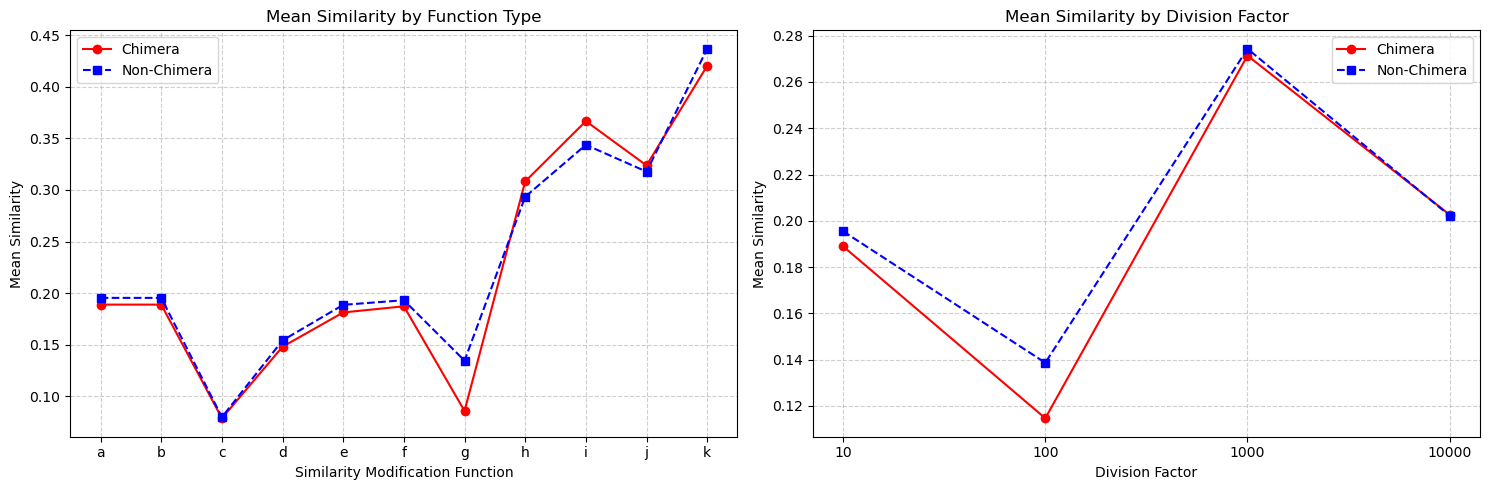

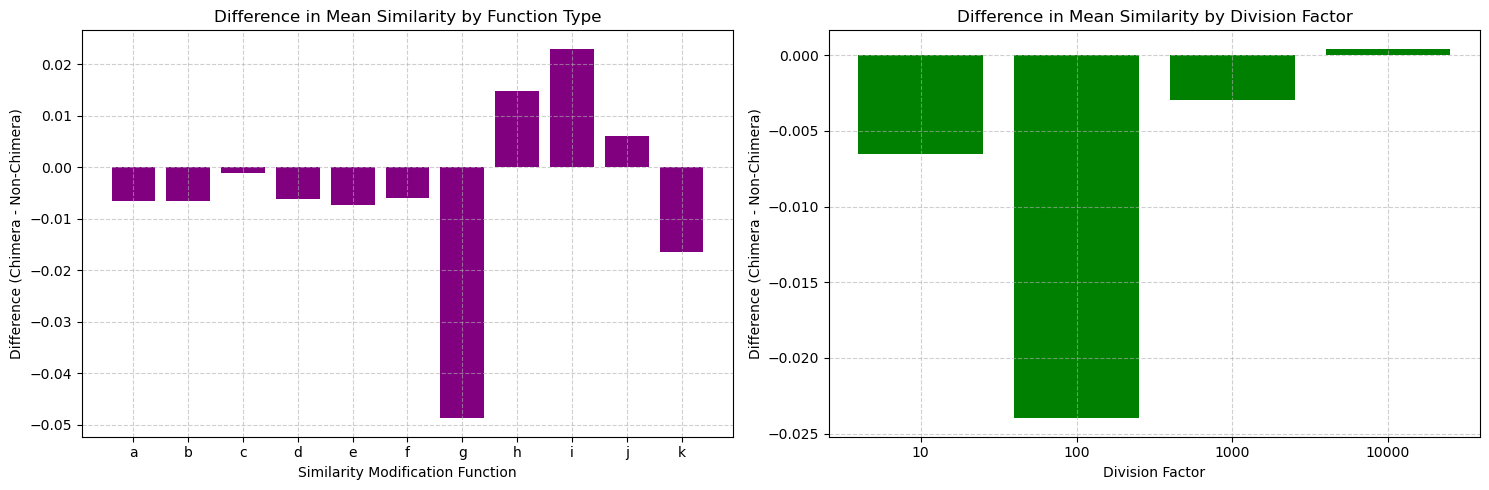

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

# Group by letters (first element of the tuple)
letter_chimera = defaultdict(list)
letter_non_chimera = defaultdict(list)

for key, values in chimera_final_means.items():
    letter = key[0]  # Extract the letter
    letter_chimera[letter].append(values)

for key, values in non_chimera_final_means.items():
    letter = key[0]  # Extract the letter
    letter_non_chimera[letter].append(values)

# Calculate mean for each letter
letter_chimera_mean = {letter: np.mean(values) for letter, values in letter_chimera.items()}
letter_non_chimera_mean = {letter: np.mean(values) for letter, values in letter_non_chimera.items()}

# Group by numbers (second element of the tuple)
number_chimera = defaultdict(list)
number_non_chimera = defaultdict(list)

for key, values in chimera_final_means.items():
    number = key[1]  # Extract the number
    number_chimera[number].append(values)

for key, values in non_chimera_final_means.items():
    number = key[1]  # Extract the number
    number_non_chimera[number].append(values)

# Calculate mean for each number
number_chimera_mean = {number: np.mean(values) for number, values in number_chimera.items()}
number_non_chimera_mean = {number: np.mean(values) for number, values in number_non_chimera.items()}

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Letters comparison
sorted_letters = sorted(set(letter_chimera_mean.keys()).union(letter_non_chimera_mean.keys()))
x_labels_letters = [str(l) for l in sorted_letters]
y_chimera_letters = [letter_chimera_mean.get(l, 0) for l in sorted_letters]
y_non_chimera_letters = [letter_non_chimera_mean.get(l, 0) for l in sorted_letters]

ax1.plot(x_labels_letters, y_chimera_letters, marker='o', linestyle='-', label='Chimera', color='red')
ax1.plot(x_labels_letters, y_non_chimera_letters, marker='s', linestyle='--', label='Non-Chimera', color='blue')
ax1.set_xlabel("Similarity Modification Function")
ax1.set_ylabel("Mean Similarity")
ax1.set_title("Mean Similarity by Function Type")
ax1.grid(True, linestyle='--', alpha=0.6)
ax1.legend()

# Plot 2: Numbers comparison
sorted_numbers = sorted(set(number_chimera_mean.keys()).union(number_non_chimera_mean.keys()))
x_labels_numbers = [str(n) for n in sorted_numbers]
y_chimera_numbers = [number_chimera_mean.get(n, 0) for n in sorted_numbers]
y_non_chimera_numbers = [number_non_chimera_mean.get(n, 0) for n in sorted_numbers]

ax2.plot(x_labels_numbers, y_chimera_numbers, marker='o', linestyle='-', label='Chimera', color='red')
ax2.plot(x_labels_numbers, y_non_chimera_numbers, marker='s', linestyle='--', label='Non-Chimera', color='blue')
ax2.set_xlabel("Division Factor")
ax2.set_ylabel("Mean Similarity")
ax2.set_title("Mean Similarity by Division Factor")
ax2.grid(True, linestyle='--', alpha=0.6)
ax2.legend()

plt.tight_layout()
plt.show()

# Also create a third plot showing the differences
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot differences for letters
letter_diff = {l: letter_chimera_mean.get(l, 0) - letter_non_chimera_mean.get(l, 0) for l in sorted_letters}
ax1.bar(x_labels_letters, [letter_diff[l] for l in sorted_letters], color='purple')
ax1.set_xlabel("Similarity Modification Function")
ax1.set_ylabel("Difference (Chimera - Non-Chimera)")
ax1.set_title("Difference in Mean Similarity by Function Type")
ax1.grid(True, linestyle='--', alpha=0.6)

# Plot differences for numbers
number_diff = {n: number_chimera_mean.get(n, 0) - number_non_chimera_mean.get(n, 0) for n in sorted_numbers}
ax2.bar(x_labels_numbers, [number_diff[n] for n in sorted_numbers], color='green')
ax2.set_xlabel("Division Factor")
ax2.set_ylabel("Difference (Chimera - Non-Chimera)")
ax2.set_title("Difference in Mean Similarity by Division Factor")
ax2.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

In [ ]:
part_similarities_for_all_taxa["chimeraREV_24486_12"]

{(7, 'a'): {(1, 2): 0.0,
  (1, 3): 0.0,
  (1, 4): 0.0,
  (1, 5): 0.0,
  (1, 6): 0.0,
  (1, 7): 0.0019267822736030828,
  (2, 3): 0.0345821325648415,
  (2, 4): 0.020338983050847456,
  (2, 5): 0.010282776349614395,
  (2, 6): 0.010282776349614395,
  (2, 7): 0.0,
  (3, 4): 0.024793388429752067,
  (3, 5): 0.024008350730688934,
  (3, 6): 0.024008350730688934,
  (3, 7): 0.003745318352059925,
  (4, 5): 0.019889502762430938,
  (4, 6): 0.019889502762430938,
  (4, 7): 0.0020964360587002098,
  (5, 6): 1.0,
  (5, 7): 0.0010395010395010396,
  (6, 7): 0.0010395010395010396},
 (7, 'b'): {(1, 2): 0.0,
  (1, 3): 0.0,
  (1, 4): 0.0,
  (1, 5): 0.0,
  (1, 6): 0.0,
  (1, 7): 0.0019267822736030828,
  (2, 3): 0.0345821325648415,
  (2, 4): 0.020338983050847456,
  (2, 5): 0.010282776349614395,
  (2, 6): 0.010282776349614395,
  (2, 7): 0.0,
  (3, 4): 0.024793388429752067,
  (3, 5): 0.024008350730688934,
  (3, 6): 0.024008350730688934,
  (3, 7): 0.003745318352059925,
  (4, 5): 0.019889502762430938,
  (4, 6): 0.019

In [ ]:
import pandas as pd

# Create rows with ID as a column
rows = []
for read_id, position_data in part_similarities_for_all_taxa.items():
    row_data = {'read_id': read_id}  # Add read_id as a column
    for position_key, pair_values in position_data.items():
        for pair, value in pair_values.items():
            # Format column name as requested: "(7, 'b')_(1, 2)"
            col_name = f"{position_key}_{pair}"
            row_data[col_name] = value
    rows.append(row_data)

# Create DataFrame with read_id as a regular column
df = pd.DataFrame(rows)
df["is_chim"] = df["read_id"].apply(lambda x: 1 if str(x).startswith("chimera") else 0)
print(df["is_chim"].value_counts())
df

is_chim
1    65
0    35
Name: count, dtype: int64


,read_id,"(7, 'a')_(1, 2)","(7, 'a')_(1, 3)","(7, 'a')_(1, 4)","(7, 'a')_(1, 5)","(7, 'a')_(1, 6)","(7, 'a')_(1, 7)","(7, 'a')_(2, 3)","(7, 'a')_(2, 4)","(7, 'a')_(2, 5)",...,"(7, 'k')_(3, 5)","(7, 'k')_(3, 6)","(7, 'k')_(3, 7)","(7, 'k')_(4, 5)","(7, 'k')_(4, 6)","(7, 'k')_(4, 7)","(7, 'k')_(5, 6)","(7, 'k')_(5, 7)","(7, 'k')_(6, 7)",is_chim
0,chimeraREV_24486_12,0.000000,0.000000,0.000000,0.000000,0.000000,0.001927,0.034582,0.020339,0.010283,...,None,None,None,None,None,None,None,None,None,1
1,Psathyrella_squamosa|DQ389687|SH1207634.09FU|r...,0.000000,0.000000,0.004520,0.002591,0.002488,0.000000,0.080925,0.043302,0.067460,...,None,None,None,None,None,None,None,None,None,0
2,Phillipsia_domingensis|UDB013048|SH1287900.09F...,0.000000,0.000000,0.002342,0.000000,0.002342,0.017391,0.024364,0.007752,0.024364,...,None,None,None,None,None,None,None,None,None,0
3,chimeraREV_28935_6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.028205,0.072500,0.072500,...,None,None,None,None,None,None,None,None,None,1
4,chimeraFWD_10407_336,0.021053,0.002519,0.013333,0.001887,0.005263,0.000000,0.056667,0.060284,0.029748,...,None,None,None,None,None,None,None,None,None,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,chimeraREV_26360_6,0.000000,0.001580,0.001580,0.001580,0.000000,0.000000,0.010147,0.010147,0.010147,...,None,None,None,None,None,None,None,None,None,1
96,chimeraREV_24858_17,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.269044,1.000000,0.253463,...,None,None,None,None,None,None,None,None,None,1
97,Enterographa_divergens|AB764057|SH1321437.09FU...,0.029491,0.029491,0.029491,0.029491,0.029491,0.000000,1.000000,1.000000,1.000000,...,None,None,None,None,None,None,None,None,None,0
98,chimeraREV_23212_34,0.000000,0.021944,0.002564,0.037288,0.000000,0.000000,0.000000,0.072500,0.005263,...,None,None,None,None,None,None,None,None,None,1


In [ ]:
df.to_csv("df_100_part_similarities_for_all_taxa.csv")

In [ ]:
input()
import pandas as pd
df = pd.read_csv("df_100_part_similarities_for_all_taxa.csv")

In [ ]:
df.columns

Index(['Unnamed: 0', 'read_id', '(7, 'a')_(1, 2)', '(7, 'a')_(1, 3)',
       '(7, 'a')_(1, 4)', '(7, 'a')_(1, 5)', '(7, 'a')_(1, 6)',
       '(7, 'a')_(1, 7)', '(7, 'a')_(2, 3)', '(7, 'a')_(2, 4)',
       ...
       '(7, 'k')_(3, 5)', '(7, 'k')_(3, 6)', '(7, 'k')_(3, 7)',
       '(7, 'k')_(4, 5)', '(7, 'k')_(4, 6)', '(7, 'k')_(4, 7)',
       '(7, 'k')_(5, 6)', '(7, 'k')_(5, 7)', '(7, 'k')_(6, 7)', 'is_chim'],
      dtype='object', length=234)

### RF on df best matches

In [9]:
base_df = pd.read_pickle("base_df_kmer7.pickle")
base_df
df = base_df

In [10]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

X = df.drop(['read_id', 'is_chim'], axis=1)
y = df['is_chim']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Train Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Print performance metrics
print("Random Forest Classifier Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

# Get feature importances
feature_importances = rf_model.feature_importances_
features = X.columns
importances = pd.DataFrame({'feature': features, 'importance': feature_importances})
importances = importances.sort_values('importance', ascending=False)

# Print top 20 most important features
print("\nTop 20 Most Important Features:")
print(importances.head(20))

# Calculate performance on training set
train_pred = rf_model.predict(X_train)
train_accuracy = accuracy_score(y_train, train_pred)
print(f"\nTraining Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")

from sklearn.model_selection import GridSearchCV

# Simplified grid search for demonstration
param_grid = {
    'n_estimators': [100],
    'max_depth': [22,25],
    'min_samples_split': [2, 5]
}

grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=20,
    scoring='accuracy',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best CV accuracy: {grid_search.best_score_:.4f}")
best_model = grid_search.best_estimator_
best_predictions = best_model.predict(X_test)
print(f"Best model test accuracy: {accuracy_score(y_test, best_predictions):.4f}")

Random Forest Classifier Results:
Accuracy: 0.9583

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.98      0.95      4504
           1       0.98      0.94      0.96      6133

    accuracy                           0.96     10637
   macro avg       0.96      0.96      0.96     10637
weighted avg       0.96      0.96      0.96     10637


Confusion Matrix:
[[4411   93]
 [ 351 5782]]

Top 20 Most Important Features:
           feature  importance
0        avg_pos_1    0.020165
1     stddev_pos_1    0.018965
71  stddev_pos_100    0.018772
3     stddev_pos_2    0.017150
7     stddev_pos_4    0.017143
67   stddev_pos_90    0.017067
59   stddev_pos_70    0.016766
10       avg_pos_6    0.016732
63   stddev_pos_80    0.016689
18      avg_pos_10    0.016633
6        avg_pos_4    0.016540
57   stddev_pos_65    0.016537
69   stddev_pos_95    0.016161
16       avg_pos_9    0.016082
61   stddev_pos_75    0.015917
53   stddev_pos_55    0

In [9]:
print(best_model)
feature_importances = best_model.feature_importances_
importances = pd.DataFrame({'feature': features, 'importance': feature_importances})
importances = importances.sort_values('importance', ascending=False)
importances.head(20)

RandomForestClassifier(max_depth=20, random_state=42)


,feature,importance
1,stddev_pos_1,0.020924
71,stddev_pos_100,0.018174
18,avg_pos_10,0.018159
57,stddev_pos_65,0.017941
0,avg_pos_1,0.017924
3,stddev_pos_2,0.017795
59,stddev_pos_70,0.017753
63,stddev_pos_80,0.017688
10,avg_pos_6,0.017394
61,stddev_pos_75,0.017323


### RF on split kmer matches

In [2]:
import os; import pandas as pd 
print(os.getcwd())
kmer_pickles_of_query_path = f"../my_data/pipi_kmers_omen"
kmer_pickles_of_query_files_list = os.listdir(kmer_pickles_of_query_path)
kmer_pickles_of_query_files_list
what_to_load = kmer_pickles_of_query_files_list[0]
ff = pd.read_pickle(kmer_pickles_of_query_path+"/"+what_to_load)
ff = ff.T
to_join_dict = {}
for nnn,pik in enumerate(kmer_pickles_of_query_files_list):
    print(nnn,len(kmer_pickles_of_query_files_list),end="\r")
    ff_2 = pd.read_pickle(kmer_pickles_of_query_path+"/"+pik).T
    for c in ff_2.columns:
        if c in ff.columns and not ff[c].equals(ff_2[c]):
            print("error",c)
        if c not in ff.columns or c not in to_join_dict.keys():
            to_join_dict[c] = ff_2[c]            
ff_2

/home/mg/ChimeraProject/scripts
18S-F___5.8S-R----10mer_0.025_thres.pickle 18S-F___5.8S-R----10mer_0.025_thres.pickle


,58A2F___ITS4----9mer_0.025_thres,58A2F___ITS4----9mer_0.1_thres,58A2F___ITS4----9mer_0.2_thres,58A2F___ITS4----10mer_0.025_thres,58A2F___ITS4----10mer_0.1_thres,58A2F___ITS4----10mer_0.2_thres,fITS7___ITS4----7mer_0.025_thres,fITS7___ITS4----7mer_0.1_thres,fITS7___ITS4----7mer_0.2_thres,fITS7___ITS4----8mer_0.025_thres,...,ITS86F___ITS4----10mer_0.2_thres,ITS9MUNngs___ITS4ngsUni----7mer_0.025_thres,ITS9MUNngs___ITS4ngsUni----7mer_0.1_thres,ITS9MUNngs___ITS4ngsUni----7mer_0.2_thres,ITS9MUNngs___ITS4ngsUni----8mer_0.025_thres,ITS9MUNngs___ITS4ngsUni----8mer_0.1_thres,ITS9MUNngs___ITS4ngsUni----8mer_0.2_thres,ITS9MUNngs___ITS4ngsUni----9mer_0.025_thres,ITS9MUNngs___ITS4ngsUni----9mer_0.1_thres,ITS9MUNngs___ITS4ngsUni----9mer_0.2_thres
o,"{'chimeraFWD_261_1': {('d', 100, 1, 2): None, ...","{'chimeraFWD_261_1': {('d', 100, 1, 2): None, ...","{'chimeraFWD_261_1': {('d', 100, 1, 2): None, ...","{'chimeraFWD_261_1': {('d', 100, 1, 2): None, ...","{'chimeraFWD_261_1': {('d', 100, 1, 2): None, ...","{'chimeraFWD_261_1': {('d', 100, 1, 2): None, ...","{'chimeraREV_236_3': {('d', 100, 1, 2): None, ...","{'chimeraREV_236_3': {('d', 100, 1, 2): None, ...","{'chimeraREV_236_3': {('d', 100, 1, 2): 0.0099...","{'chimeraREV_236_3': {('d', 100, 1, 2): None, ...",...,"{'chimeraREV_245_1': {('d', 100, 1, 2): None, ...","{'chimeraFWD_256_1': {('d', 100, 1, 2): None, ...","{'chimeraFWD_256_1': {('d', 100, 1, 2): None, ...","{'chimeraFWD_256_1': {('d', 100, 1, 2): None, ...","{'chimeraFWD_256_1': {('d', 100, 1, 2): None, ...","{'chimeraFWD_256_1': {('d', 100, 1, 2): None, ...","{'chimeraFWD_256_1': {('d', 100, 1, 2): None, ...","{'chimeraFWD_256_1': {('d', 100, 1, 2): None, ...","{'chimeraFWD_256_1': {('d', 100, 1, 2): None, ...","{'chimeraFWD_256_1': {('d', 100, 1, 2): None, ..."


In [17]:
ff

,18S-F___5.8S-R----7mer_0.025_thres,18S-F___5.8S-R----7mer_0.1_thres,18S-F___5.8S-R----7mer_0.2_thres,18S-F___5.8S-R----8mer_0.025_thres,18S-F___5.8S-R----8mer_0.1_thres,18S-F___5.8S-R----8mer_0.2_thres,18S-F___5.8S-R----9mer_0.025_thres,18S-F___5.8S-R----9mer_0.1_thres,18S-F___5.8S-R----9mer_0.2_thres,18S-F___5.8S-R----10mer_0.025_thres
o,"{'chimeraREV_394_1': {('d', 100, 1, 2): None, ...","{'chimeraREV_394_1': {('d', 100, 1, 2): None, ...","{'chimeraREV_394_1': {('d', 100, 1, 2): None, ...","{'chimeraREV_394_1': {('d', 100, 1, 2): None, ...","{'chimeraREV_394_1': {('d', 100, 1, 2): None, ...","{'chimeraREV_394_1': {('d', 100, 1, 2): None, ...","{'chimeraREV_394_1': {('d', 100, 1, 2): None, ...","{'chimeraREV_394_1': {('d', 100, 1, 2): None, ...","{'chimeraREV_394_1': {('d', 100, 1, 2): None, ...","{'chimeraREV_394_1': {('d', 100, 1, 2): None, ..."


In [43]:
new_ff = pd.DataFrame(to_join_dict)
new_ff = pd.concat([new_ff,ff],axis=1)
aa = new_ff["fITS7___ITS4----7mer_0.025_thres"][0].values()
list(aa)

/tmp/ipykernel_17561/3386747921.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  aa = new_ff["fITS7___ITS4----7mer_0.025_thres"][0].values()


[{('d', 100, 1, 2): None,
  ('d', 100, 1, 3): None,
  ('d', 100, 1, 4): None,
  ('d', 100, 1, 5): None,
  ('d', 100, 2, 3): 1.0,
  ('d', 100, 2, 4): 0.3358208955223881,
  ('d', 100, 2, 5): None,
  ('d', 100, 3, 4): 0.3358208955223881,
  ('d', 100, 3, 5): None,
  ('d', 100, 4, 5): None},
 {('d', 100, 1, 2): None,
  ('d', 100, 1, 3): 0.05371900826446281,
  ('d', 100, 1, 4): None,
  ('d', 100, 1, 5): None,
  ('d', 100, 2, 3): None,
  ('d', 100, 2, 4): None,
  ('d', 100, 2, 5): None,
  ('d', 100, 3, 4): None,
  ('d', 100, 3, 5): None,
  ('d', 100, 4, 5): None},
 {('d', 100, 1, 2): None,
  ('d', 100, 1, 3): None,
  ('d', 100, 1, 4): None,
  ('d', 100, 1, 5): None,
  ('d', 100, 2, 3): None,
  ('d', 100, 2, 4): None,
  ('d', 100, 2, 5): None,
  ('d', 100, 3, 4): None,
  ('d', 100, 3, 5): None,
  ('d', 100, 4, 5): None},
 {('d', 100, 1, 2): None,
  ('d', 100, 1, 3): None,
  ('d', 100, 1, 4): None,
  ('d', 100, 1, 5): 0.2413793103448276,
  ('d', 100, 2, 3): None,
  ('d', 100, 2, 4): None,
  ('d

In [39]:
df

,read_id,is_chim,avg_pos_1,stddev_pos_1,avg_pos_2,stddev_pos_2,avg_pos_3,stddev_pos_3,avg_pos_4,stddev_pos_4,...,avg_pos_80,stddev_pos_80,avg_pos_85,stddev_pos_85,avg_pos_90,stddev_pos_90,avg_pos_95,stddev_pos_95,avg_pos_100,stddev_pos_100
0,chimeraREV_275_3,1,0.354240,0.181901,0.378414,0.197029,0.385101,0.202820,0.373215,0.186462,...,0.456704,0.227907,0.457884,0.228884,0.457081,0.230207,0.456926,0.231732,0.457664,0.231624
1,Pulveroboletus_ravenelii|OM987309|SH1292419.09...,0,0.722139,0.284229,0.655376,0.286388,0.568299,0.272724,0.580969,0.265672,...,0.464989,0.261397,0.462647,0.260032,0.464809,0.261284,0.465684,0.260155,0.465773,0.260601
2,Pluteus_heteromarginatus|ON006977|SH0962057.09...,0,0.683158,0.297043,0.533636,0.287005,0.539214,0.275584,0.569135,0.276006,...,0.490622,0.279281,0.495732,0.278931,0.496509,0.279647,0.496770,0.280002,0.497805,0.280630
3,Amanita_sp|ON080993|SH1058047.09FU|reps|k__Fun...,0,0.493243,0.202256,0.486217,0.243613,0.503329,0.242246,0.544279,0.257274,...,0.483593,0.252048,0.483940,0.252826,0.485331,0.253025,0.485291,0.254331,0.484855,0.254642
4,GS28_sp|UDB0765401|SH0951657.09FU|reps|k__Fung...,0,0.639942,0.284783,0.526536,0.277298,0.507248,0.273349,0.513660,0.278653,...,0.473354,0.254718,0.476524,0.254762,0.477287,0.255622,0.476246,0.254026,0.475805,0.253648
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35451,chimeraREV_134_6,1,0.703803,0.286124,0.653911,0.241846,0.682392,0.237782,0.673558,0.239145,...,0.646145,0.290414,0.647385,0.289334,0.648068,0.288876,0.648549,0.288184,0.644804,0.288396
35452,chimeraREV_69_3,1,0.747929,0.241781,0.674768,0.218029,0.687397,0.233377,0.677356,0.231360,...,0.708398,0.223950,0.708868,0.221966,0.706283,0.222578,0.706074,0.223582,0.706319,0.223272
35453,chimeraFWD_141_6,1,0.739292,0.249071,0.729316,0.249551,0.687571,0.229876,0.681984,0.243013,...,0.689890,0.236510,0.688277,0.238356,0.689186,0.238603,0.687231,0.239302,0.689664,0.238157
35454,chimeraREV_569_1,1,0.746768,0.244909,0.718572,0.264047,0.682550,0.236517,0.670815,0.236477,...,0.696283,0.234731,0.697148,0.234698,0.700209,0.232277,0.699471,0.232702,0.700487,0.232820


I will make fasta from reads from Simera so I can test it on Usearch and Vsearch

In [26]:
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq

all_amps[list(all_amps.keys())[3]][:10]
all_amps_all_seq_one_fasta = []
for k,v in all_amps.items():
    v = list(map(lambda x: (x[0]+f"_-_{k}",x[1]), v))
    all_amps_all_seq_one_fasta.extend(v)

len(all_amps_all_seq_one_fasta)
all_amps_all_seq_one_fasta[:10]
seq_records = []
for seq_id, sequence in all_amps_all_seq_one_fasta:
    record = SeqRecord(
        Seq(sequence),
        id=seq_id,
        description=""
    )
    seq_records.append(record)

SeqIO.write(seq_records, "../my_data/all_simera_for_uchime.fasta", "fasta")


35456

In [ ]:
a = list(map(lambda x: [i for i in x if str(i).isalpha()][0],importances.feature))
from collections import Counter
counts = Counter(a[:100])
counts

Counter({'c': 18,
         'd': 17,
         'a': 13,
         'e': 12,
         'g': 12,
         'f': 11,
         'b': 10,
         'h': 6,
         'i': 1})

In [ ]:
importances.head(50)

,feature,importance
57,"(7, 'c')_(4, 5)",0.028783
40,"(7, 'b')_(5, 7)",0.027118
45,"(7, 'c')_(1, 5)",0.020988
82,"(7, 'd')_(5, 7)",0.019766
124,"(7, 'f')_(5, 7)",0.019689
103,"(7, 'e')_(5, 7)",0.019568
19,"(7, 'a')_(5, 7)",0.018832
42,"(7, 'c')_(1, 2)",0.017360
137,"(7, 'g')_(3, 4)",0.016106
36,"(7, 'b')_(4, 5)",0.015154
